### PROJET - HOUSING

In [1]:
#les biblioteques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.formula.api as smf
import statsmodels.stats.anova as smsa
import arviz as az
import pymc as pm
from sklearn.preprocessing import StandardScaler

## le jeux de donnée

In [ ]:

Housing=pd.read_csv('housing.csv')


In [3]:
Housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Nous constatons l’absence de données pour la variable correspondant au nombre total de chambres dans certaines observations, ce qui nous contraint à supprimer un certain nombre de lignes du jeu de données afin de garantir la qualité de l’analyse.

In [4]:
Housing.dropna(inplace=True)

# Introduction

---
Le marché du logement en Californie est connu pour ses prix élevés et ses fortes inégalités selon les régions.


Dans ce projet, l’objectif est de prédire le prix médian des habitations en fonction des caractéristiques propres à chaque zone ou ville : revenus, densité de population, proximité de l’océan, etc.

L’idée, c’est de voir comment ces variables influencent les prix, et d’utiliser des outils de data science pour construire un modèle prédictif. Ce travail permet non seulement d’explorer les dynamiques du marché immobilier californien, mais aussi de mieux comprendre comment certains facteurs peuvent faire grimper (ou baisser) le prix d’un logement.



Nous allons commencer par une analyse du jeu de données puis nous nous poursuivrons par la creation de multiples modele de regression  afin d’obtenir une idée des relations entre les variables explicatives pertiennentes et le prix médian des logements. Cette étape servira également à identifier les variables les plus pertinentes grâce à des critères comme la significativité statistique ou le R² ajusté. Ensuite, nous approfondirons l’analyse en étudiant individuellement les variables sélectionnées, afin de mieux comprendre leur impact spécifique sur le prix du logement.


In [5]:
len(Housing) , Housing.columns

(20433,
 Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
        'total_bedrooms', 'population', 'households', 'median_income',
        'median_house_value', 'ocean_proximity'],
       dtype='object'))

Le jeu de données contient **20 433 observations** et **10 variables** décrivant les caractéristiques démographiques, économiques et géographiques de différentes zones résidentielles en Californie. **Chaque ligne représente une zone géographique agrégée**, et les colonnes sont les suivantes :

- **longitude :** la longitude de la zone (coordonnée géographique).
- **latitude :** la latitude de la zone.
- **housing_median_age :** l’âge médian des logements dans la zone.
- **total_rooms :** le nombre total de pièces (chambres, salons, etc.) dans l’ensemble des logements de la zone.
- **total_bedrooms :** le nombre total de chambres dans la zone.
- **population :** le nombre total d’habitants.
- **households :** le nombre total de ménages (groupes de personnes partageant un logement).
- **median_income :** le revenu médian des habitants (en dizaines de milliers de dollars).
- **median_house_value :** la valeur médiane des logements dans la zone (en dollars).
- **ocean_proximity :** une variable catégorielle indiquant la proximité de la zone avec l’océan (par exemple : <1H OCEAN, INLAND, ISLAND, NEAR BAY, NEAR OCEAN).



In [6]:
fig = px.scatter_mapbox(Housing, lat="latitude", lon="longitude", color="median_house_value", size="population",
                        color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10,
                        mapbox_style="carto-positron")
fig.show()

La carte ci-dessus représente la répartition géographique des zones résidentielles en Californie, avec une coloration en fonction de la valeur médiane des logements (median_house_value).

On observe clairement que les zones côtières, notamment autour de San Francisco, Los Angeles et San Diego, affichent les prix les plus élevés (points allant du rouge au noir selon la palette utilisée).

À l’inverse, les zones plus éloignées de la côte (partie centrale de l’État) présentent des valeurs beaucoup plus faibles, visibles par les points bleus clairs.

La taille des points, proportionnelle à la population, montre également que les grandes agglomérations concentrent à la fois plus d’habitants et des logements plus chers.

Cette carte confirme donc l’intuition selon laquelle la proximité de l’océan, l’urbanisation et la densité de population sont des facteurs clés influençant le prix du logement.

In [7]:
Housing=Housing.drop(columns=['longitude','latitude'])

# I- Analyse descriptive du jeu de donnee

---

Avant de pouvoir construire un modèle prédictif, il est essentiel de comprendre la structure et la distribution des variables du jeu de données. Cette étape permet d’identifier les éventuelles anomalies, les corrélations fortes, ou encore les variables nécessitant un traitement particulier.



## A- Statistiques descriptives

In [8]:
(Housing[Housing['median_house_value'] == Housing['median_house_value'].min()])

housing_median_age  total_rooms  total_bedrooms  population  \
2521                 16.0        255.0            73.0        85.0   
2799                 19.0        619.0           239.0       490.0   
9188                 52.0        803.0           267.0       628.0   
19802                36.0         98.0            28.0        18.0   

       households  median_income  median_house_value ocean_proximity  
2521         38.0         1.6607             14999.0          INLAND  
2799        164.0         2.1000             14999.0          INLAND  
9188        225.0         4.1932             14999.0          INLAND  
19802         8.0         0.5360             14999.0          INLAND

**La valeur médiane de logement la plus faible dans notre jeu de données est de 14 999 dollars**, ce qui nous donne un premier aperçu sur l’impact potentiel des variables explicatives.

Quatre régions présentent exactement cette valeur minimale. En examinant leur position géographique on remarque qu'elles sont situées dans des zones **non côtières**, ce qui laisse penser que la **localisation géographique** joue un rôle déterminant.

Ces quatre régions les moins couteuses partagent donc une caractéristiques principales : **l’absence d’accès à la côte.**
Toutefois, aucune autre variable ne semble les relier de manière évidente, ce qui suggère **une forme d’hétérogénéité non expliquée par les seules variables géographiques.**



Cela renforce l’intérêt d’analyser en profondeur l’effet des autres variables socio-économiques dans notre modèle, notamment pour mieux comprendre les écarts extrêmes dans la distribution des prix.



In [9]:
(Housing[Housing['median_house_value'] == Housing['median_house_value'].max()]).describe()

housing_median_age   total_rooms  total_bedrooms   population  \
count          958.000000    958.000000      958.000000   958.000000   
mean            33.817328   2962.031315      501.782881  1113.026096   
std             13.020803   2167.619458      398.408898   815.263027   
min              2.000000      8.000000        1.000000    13.000000   
25%             24.250000   1668.500000      266.000000   637.000000   
50%             34.000000   2514.500000      401.000000   925.000000   
75%             44.000000   3539.750000      609.500000  1346.250000   
max             52.000000  18132.000000     5419.000000  7431.000000   

        households  median_income  median_house_value  
count   958.000000     958.000000               958.0  
mean    465.686848       7.823533            500001.0  
std     361.908488       3.240095                 0.0  
min       1.000000       0.499900            500001.0  
25%     252.000000       5.242650            500001.0  
50%     373.500000       7.721350            500001.0  
75%     573.500000      10.109325            500001.0  
max    4930.000000      15.000100            500001.0

À l’inverse, si l’on s’intéresse aux zones où les logements sont les plus chers, on remarque qu’elles sont quasiment toutes situées le long de la côte californienne, principalement autour des grandes métropoles comme San Francisco, Los Angeles et San Diego.

Ces zones affichent **une valeur médiane plafonnée à 500 001 dollars**, ce qui correspond à la valeur maximale autorisée dans le dataset.


Il est question de 938 zones partageant plusieurs caractéristiques communes : un revenu médian élevé, une densité de population importante, une forte concentration de ménages, et bien sûr, **une proximité de l’océan** (ocean_proximity étant souvent égal à NEAR OCEAN ou NEAR BAY).
Cela correspond au informations que nous avons tiré de la carte plus haut.

Contrairement aux zones les moins chères, qui n’avaient en commun que leur isolement géographique, les zones les plus chères cumulent plusieurs facteurs favorables. Cela confirme l'idée que certains effets peuvent se renforcer mutuellement.

In [10]:
formula = 'median_house_value ~ C(ocean_proximity)'
model = smf.ols(formula, data=Housing).fit()
print(smsa.anova_lm(model, typ=2))

                          sum_sq       df            F  PR(>F)
C(ocean_proximity)  6.478688e+13      4.0  1594.710397     0.0
Residual            2.074776e+14  20428.0          NaN     NaN


Les résultats de cette ANOVA (p-value = 0.0) indiquent que la proximité à l’océan explique une part substantielle de la variance du prix des logements, ce qui confirme les observations précédentes.

Elle capte des différences structurelles importantes entre les zones côtières et les zones intérieures en Californie.


In [11]:
Housing.describe()

housing_median_age   total_rooms  total_bedrooms    population  \
count        20433.000000  20433.000000    20433.000000  20433.000000   
mean            28.633094   2636.504233      537.870553   1424.946949   
std             12.591805   2185.269567      421.385070   1133.208490   
min              1.000000      2.000000        1.000000      3.000000   
25%             18.000000   1450.000000      296.000000    787.000000   
50%             29.000000   2127.000000      435.000000   1166.000000   
75%             37.000000   3143.000000      647.000000   1722.000000   
max             52.000000  39320.000000     6445.000000  35682.000000   

         households  median_income  median_house_value  
count  20433.000000   20433.000000        20433.000000  
mean     499.433465       3.871162       206864.413155  
std      382.299226       1.899291       115435.667099  
min        1.000000       0.499900        14999.000000  
25%      280.000000       2.563700       119500.000000  
50%      409.000000       3.536500       179700.000000  
75%      604.000000       4.744000       264700.000000  
max     6082.000000      15.000100       500001.000000

Les variables **population, total_rooms et total_bedrooms** présentent une grande dispersion, comme en témoignent leurs écarts-types particulièrement élevés (respectivement 1133 - 2185 421). Cela reflète une forte hétérogénéité entre les zones résidentielles, certaines étant très denses et urbanisées, tandis que d'autres sont beaucoup plus rurales ou faiblement peuplées.


Cette variabilité importante peut entraîner des effets extrêmes dans la modélisation, surtout dans le choix de nos à priori.<p>
Je fais donc le choix **de retirer les valeurs extremes** pour augmenter la robustesse.

In [12]:
numerical_features = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
Q1 = Housing[numerical_features].quantile(0.25)
Q3 = Housing[numerical_features].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outlier removal
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
Housing = Housing[~((Housing[numerical_features] < lower_bound) | (Housing[numerical_features] > upper_bound)).any(axis=1)]

## B- Analyse des corrélations

Il est essentiel d'examiner les relations entre les variables numériques du dataset afin de repérer les éventuelles redondances, les relations linéaires fortes ou encore des risques de multicolinéarité des variables explicatives qui pourraient biaiser l’interprétation des coefficients dans une régression linéaire multiple.

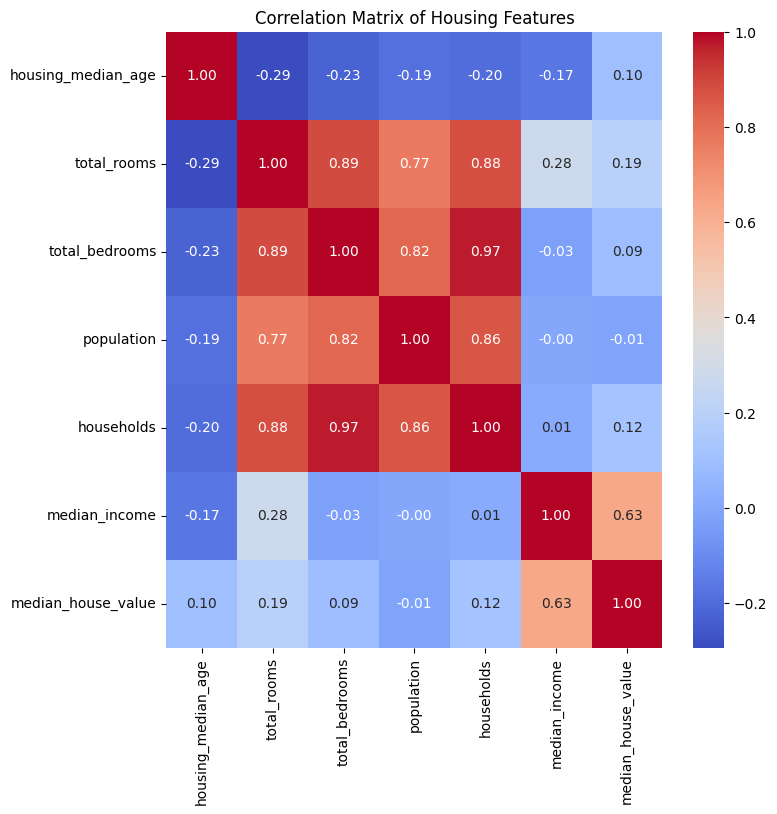

In [13]:
x=Housing.drop(columns=['ocean_proximity'])
plt.figure(figsize=(8, 8))
sns.heatmap(x.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Housing Features')
plt.show()


La matrice de corrélation des variables numériques du jeu de données révèle plusieurs tendances intéressantes :

- total_rooms, total_bedrooms, population et households sont très fortement corrélées entre elles (corrélations > 0.85), ce qui confirme leur redondance structurelle : elles décrivent toutes différentes dimensions de la taille ou de la densité d’une zone.  **La corrélation entre total_bedrooms et households atteint 0.97, ce qui est quasiment une colinéarité parfaite.**



- les variables comme **housing_median_age et median_income sont modérément corrélées aux autres.** Cela peut être un atout pour la modélisation, car elles pourraient apporter de l'information nouvelle non captée par les autres variables.


- La variable la plus corrélée avec la valeur médiane des logements (median_house_value), qui est notre variable cible, **est median_income (r = 0.63)**. On imagine que les ménages les plus aisés vivent dans les zones où les prix de l'immobilier sont les plus élevés.

- Les autres variables ont des corrélations beaucoup plus faibles avec la cible ce qui suggère qu’elles ont un rôle explicatif secondaire mais quand même **supposément utile**.

## C- Sélection de variable

L'objectif est de sélectionner les variables les plus pertinentes pour prédire 'median_house_value' sans que la colinéarité des variables explicatives réduisent la significativité des coefficients.

1. `total_rooms, total_bedrooms, households` et `population` sont trop fortement corrélées entre elles.  Sachant que ces 4 vrariables traduisent la meme information, je decide de garder **`"households"`** car elle a correlation significative avec la variabe (r=0,12) et elle est la moins redondente. C'est à dire qu'elle est moins correle aux autres variables explicatves,

2. **`median_income`**	a une corrélation forte avec le prix medians des logements (r = 0.63) donc il s'agit d'une variable pertinente.

3.	La variable catégorielle **`ocean_proximity`** s'est montré très pertinente selon la mesure de l'ANOVA.

4. La variable **`housing_median_age`** 	aussi est peu corrélée aux autres, mais liée à la variable cible ce qui fait d'elle une bonne variable explicative.




In [14]:
Housing=Housing.drop(columns=['total_rooms','total_bedrooms','population'])
Og_Housing=Housing.copy()

# II- Régression linéaire bayésienne

Après avoir sélectionné les variables explicatives les plus pertinentes, nous cherchons désormais à modéliser la relation entre ces variables et la valeur médiane des logements à l'aide d'une régression linéaire.


L'intérêt de cette démarche est, d'une part, de modéliser l’incertitude des paramètres du modèle via des distributions a posteriori.

D’autre part, elle offre une flexibilité importante pour intégrer des connaissances a priori ou pour modéliser des effets complexes (non-linéarité, erreurs hétéroscédastiques, etc.).


Pour se faire, nous allons considérer une relation linéaire simple entre la valeur médiane des logements (median_house_value) et un sous-ensemble de variables explicatives sélectionnées précédemment.


Les coefficients associés à chaque variable seront estimés via une inférence bayésienne à l’aide de l’échantillonnage MCMC (Markov Chain Monte Carlo).

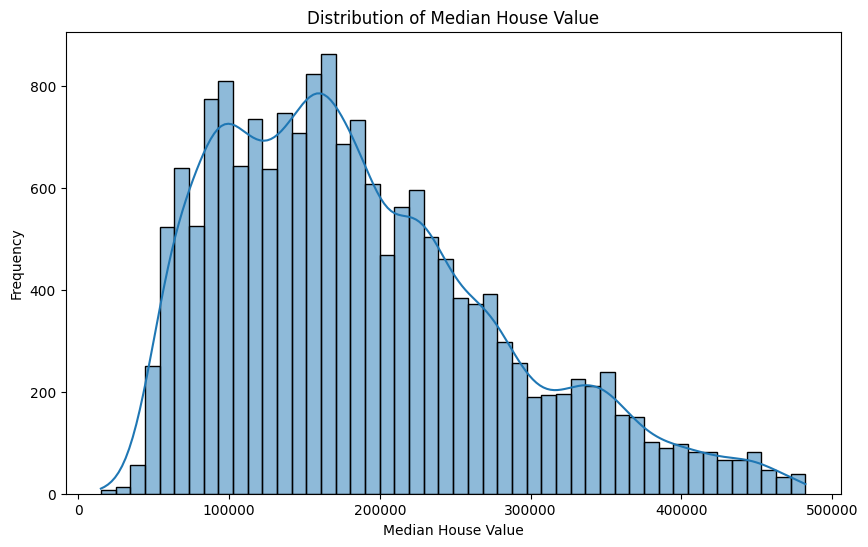

In [15]:
# Distribution of median_house_value
plt.figure(figsize=(10, 6))
sns.histplot(Housing['median_house_value'], kde=True)
plt.title('Distribution of Median House Value')
plt.xlabel('Median House Value')
plt.ylabel('Frequency')
plt.show()


La variable median_house_value est une variable continue dont la distribution présente une queue lourde ainsi qu’une asymétrie marquée. Ce comportement indique que les logements très chers sont relativement fréquents.

Nous savons que le choix de la distribution à utiliser comme vraisemblance dépend a fois de la forme empirique de la variable et de la robustesse souhaitée du modèle face aux outliers.
Voila pourquoi nous optons pour differents modèles dont -> <p>
- Une distribution skew-normal permet de mieux capturer l’asymétrie observée. Ou,
- une distribution de Student est robuste aux valeurs extrêmes
---

Pré-traitement
--
Avant tout, il est nécessaire de faire un prétraitement sur nos données d'observation


Le jeu de données original contient plus de 10 000 observations, ce qui peut représenter une charge computationnelle importante, notamment pour des traitements plus lourds comme l’inférence bayésienne avec PyMC.


Afin d'alléger cette contrainte et d'assurer un traitement plus fluide, un sous-échantillonnage a été réalisé à l'aide de la fonction `train_test_split` de sklearn.

In [16]:
from sklearn.model_selection import train_test_split

# Échantillonnage stratifié basé sur la colonne 'ocean_proximity'
Housing, _ = train_test_split(Og_Housing, test_size=0.80, stratify=Og_Housing['ocean_proximity'], random_state=42)
housing2=Housing.copy()
len(Housing),len(Og_Housing)

(3486, 17434)

Dans mon cas, j'ai choisi de conservé **20 % des données ce qui correspond à 3486 lignes.**

L’échantillonnage a été effectué de manière stratifiée selon la variable `ocean_proximity` afin de préserver la représentativité des différentes catégories géographiques présentes dans le jeu initial.

L'objectif étant de pouvoir travailler efficacement avec un échantillon tout en conservant la diversité structurelle des données.

La variable ocean_proximity contient des valeurs catégorielles, ce qui n’est pas directement exploitable dans un modèle de régression. Pour pouvoir l’utiliser, on doit la transformer en variables numériques via un encodage approprié.

In [17]:
location_dummies = pd.get_dummies(Housing['ocean_proximity'], prefix='loc_', drop_first=True)

Housing = pd.concat([Housing, location_dummies], axis=1)
house_value=Housing['median_house_value'].values
# Supprimer la colonne d'origine 'location' si plus nécessaire
Housing = Housing.drop('ocean_proximity', axis=1)
Housing2 = Housing.copy()


**On peut maintenant inclure ocean_proximity dans le modèle de régression linéaire bayésienne via ses dummies.**

In [18]:
Housing.describe(),print('\n'),Og_Housing.describe()

(       housing_median_age   households  median_income  median_house_value
 count         3486.000000  3486.000000    3486.000000         3486.000000
 mean            29.499713   418.240964       3.559972       185848.909639
 std             12.229952   204.165258       1.454313        94609.486077
 min              1.000000     3.000000       0.499900        14999.000000
 25%             19.000000   271.000000       2.446025       110975.000000
 50%             30.000000   390.000000       3.375000       168800.000000
 75%             38.000000   539.000000       4.475900       240900.000000
 max             52.000000  1057.000000       7.981300       479500.000000,
 None,
        housing_median_age    households  median_income  median_house_value
 count        17434.000000  17434.000000   17434.000000        17434.000000
 mean            29.489216    416.806126       3.575593       187056.188826
 std             12.214437    205.412687       1.443540        93742.859159
 min         

**Remarque :** <p>On note que le sous échantillon reste statistiquement représentatif des données observé, ce qui en fait une base solide pour construire et tester des modèles sans surcharger les ressources machine.

Afin d’entraîner efficacement un modèle de régression, il est nécessaire de mettre les variables sur une échelle comparable, surtout lorsqu’elles ont des ordres de grandeur très différents (ex : revenu médian vs âge médian des logements).

Cela permet également d’accélérer la convergence des algorithmes d’inférence, en particulier lors de l’échantillonnage MCMC.

Le code suivant effectue une standardisation (centrage-réduction) sur les colonnes numériques clés :

In [19]:
# --- Standardisation
cols_to_scale = ['median_income', 'housing_median_age', 'households','median_house_value']

scalers = {}
for col in cols_to_scale:
    scaler = StandardScaler()
    Housing[col] = scaler.fit_transform(Housing[[col]])
    scalers[col] = scaler  # on garde chaque scaler pour pouvoir inverse_transform plus tard

cols = ['median_income', 'housing_median_age', 'households']
X = Housing[cols + location_dummies.columns.tolist()].values
X = X.astype(float)
y = Housing['median_house_value'].values

name=['median_income', 'housing_median_age', 'households']+location_dummies.columns.tolist()

- Chaque variable est transformée pour avoir une moyenne de 0 et un écart-type de 1.
- Les objets `StandardScaler` sont stockés dans un dictionnaire (scalers) pour pouvoir effectuer un inverse transform plus tard, notamment pour réinterpréter les résultats dans leur unité d’origine.

## A- Modèle linéaire avec distribution normale
---
Le modèle construit ici est une régression linéaire bayésienne utilisant une vraisemblance normale pour modéliser la variable cible y (la valeur médiane des logements).

- alpha est l’ordonnée à l’origine (l’intercept), supposée suivre une distribution normale centrée réduite (mu=0, sigma=5).
- beta contient les coefficients de régression pour chaque variable explicative. On les suppose également issus d’une loi normale centrée, ce qui permet d’introduire une incertitude a priori symétrique autour de zéro.

In [20]:
with pm.Model() as normal_linear_model:
    # Ensure X is of numeric type, for instance by converting to float:

    # Priors pour les coefficients
    alpha = pm.Normal('alpha', mu=0, sigma=5)
    beta = pm.Normal('beta', mu=0, sigma=5, shape=X.shape[1])  # Shape correspond à la dimension de X (nombre de features)

    # Priors pour l'erreur
    sigma = pm.HalfNormal('sigma', sigma=1)

    # La régression linéaire
    mu = alpha + pm.math.dot(X, beta)

    # La vraisemblance (ou l'observation)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

Ce modèle est intéressant car il permet non seulement d’obtenir des estimations ponctuelles des coefficients, mais aussi des intervalles de crédibilité, ce qui donne une idée de l’incertitude autour de chaque paramètre.


Il est facile à étendre (on pourrait remplacer Normal par SkewNormal ou StudentT pour capter mieux la forme des données).

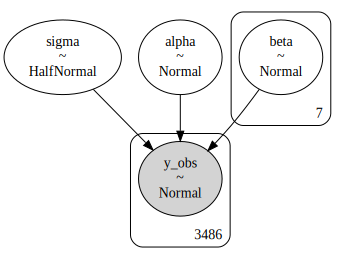

In [21]:
pm.model_to_graphviz(normal_linear_model)

In [22]:
with normal_linear_model:
    trace1 = pm.sample(500, tune=500, target_accept=0.99, idata_kwargs={'log_likelihood': True})

Output()

In [23]:
trace1.posterior = trace1.posterior.assign_coords(beta_dim_0=name)

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

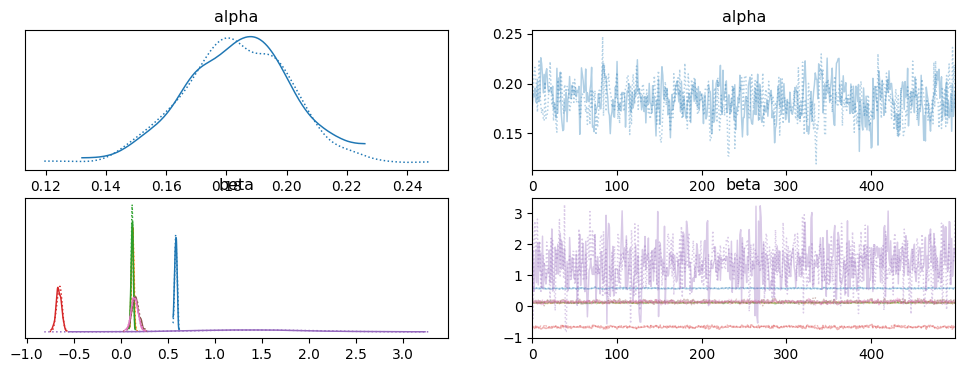

In [24]:
az.plot_trace(trace1, var_names=['alpha', 'beta'])

Ces tracés permettent de visualiser le comportement des chaînes au cours de la simulation et d'évaluer si elles ont convergé vers la distribution cible.

**Un mélange adéquat des chaînes et une stationnarité apparente suggèrent une bonne convergence.**

## B- Modèle de régression de Poisson

Ici, on modélise la variable cible y (décalée par +3) en supposant qu’elle suit une distribution de Poisson, adaptée à des comptages ou données entières positives.

On ajuste aussi les variables explicatives X et la target y avec un décalage +3 pour éviter les problèmes de log sur des valeurs potentiellement nulles ou négatives.

La Poisson est définie pour k ∈ ℕ, mais certains algos peuvent buguer avec trop de zéros).


- alpha est l’intercept.
- beta sont les coefficients associés à chaque variable explicative.


Tous deux sont supposés a priori normaux : pas de connaissance spécifique mais centrés autour de zéro, avec une variance modérée.

On suppose que la variable réponse suit une loi de Poisson paramétrée par mu.


In [25]:
A=X+3
with pm.Model() as poisson_linear_model:
# Ensure A is of numeric type, for instance by converting to float:
    alpha = pm.Normal('alpha', mu=0, sigma=5)  # Intercept
    beta = pm.Normal('beta', mu=0, sigma=5, shape=A.shape[1])
    eta = alpha + pm.math.dot(A, beta) # Log-lambda
    mu = pm.math.exp(eta)
    # La vraisemblance : y suit une distribution de Poisson avec le paramètre mu
    y_obs = pm.Poisson('y_obs', mu=mu, observed=y+3)


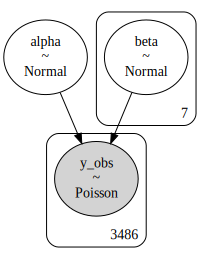

In [26]:
pm.model_to_graphviz(poisson_linear_model)

In [27]:
with  poisson_linear_model:
    trace2 = pm.sample(500, tune=500, target_accept=0.99, idata_kwargs={'log_likelihood': True})

Output()

In [28]:
trace2.posterior = trace2.posterior.assign_coords(beta_dim_0=name)

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

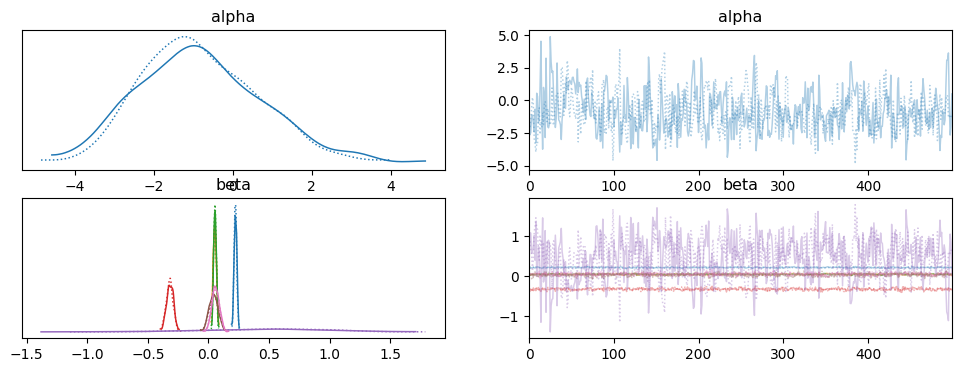

In [29]:
az.plot_trace(trace2, var_names=['alpha', 'beta'])

##C- Modèle de régression linéaire avec distribution SkewNormal

On cherche ici à capturer une asymétrie dans la distribution de la variable cible y (median_house_value).

Contrairement au modèle gaussien classique (symétrique), on suppose que les erreurs suivent une loi normale asymétrique, dite SkewNormal, avec un paramètre α qui contrôle la direction et l’intensité de l’asymétrie.

On desire capturer une distribution déséquilibrée (skewed), qui reflète mieux la réalité du marché immobilier californien, où les prix peuvent présenter une longue queue à droite (logements très chers mais rares).

In [30]:
with pm.Model() as skewnormal_linear_model:
    # Ensure X is of numeric type, for instance by converting to float:
    X = X.astype(float)  # Convert X to float dtype

    alpha = pm.Normal('alpha', mu=0, sigma=5)
    beta = pm.Normal('beta', mu=0, sigma=5, shape=X.shape[1])
    a= pm.Normal("a", mu=0, sigma=5)

    sigma = pm.HalfNormal('sigma', sigma=1)

    # La régression linéaire
    mu = alpha + pm.math.dot(X, beta)

    # La vraisemblance
    y_obs = pm.SkewNormal('y_obs', mu=mu, sigma=sigma, alpha=a, observed=y)

- alpha : l'intercept de la régression.
- beta : les coefficients associés à chaque variable explicative.
- sigma : l'écart-type des résidus.
- a : le paramètre d’asymétrie de la SkewNormal<p>
Si a > 0, la queue droite est plus lourde (positive skew).<p>
Si a < 0, la queue gauche est plus lourde (negative skew).

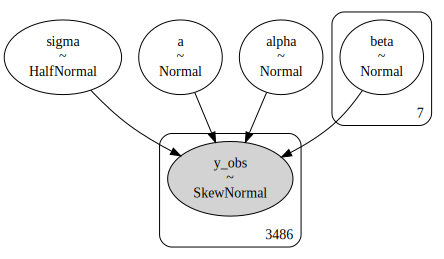

In [31]:
pm.model_to_graphviz(skewnormal_linear_model)

In [32]:
with skewnormal_linear_model:
    trace3 = pm.sample(500, tune=500, target_accept=0.99, idata_kwargs={'log_likelihood': True})

Output()

**Pourquoi ce modèle est une bonne idée ici ?**
Le modèle SkewNormal permet une meilleure flexibilité tout en restant relativement simple et rapide à inférer.
Il donne une meilleure robustesse face aux outliers ou à la non-normalité des résidus.

In [33]:
trace3.posterior = trace3.posterior.assign_coords(beta_dim_0=name)

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

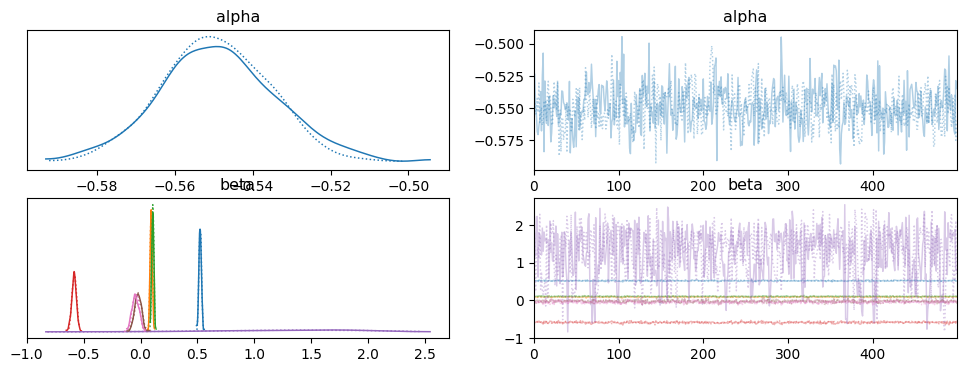

In [34]:
az.plot_trace(trace3, var_names=['alpha', 'beta'])

## D- Modèle bayésien Bimodal

Ce type de modèle est utile lorsque la variable cible (y) semble être générée à partir de deux distributions différentes.

On s'attaques à un modèle mixte, où il y a deux distributions avec une probabilité différente d'appartenance à chacune.

Cela peut refléter des comportements différents dans les prix des logements selon les régions, les quartiers, etc.

In [35]:

# Définition du modèle PyMC Bimodal
with pm.Model() as model_linear_bimodal:
     #Priors sur les coefficients (normaux centrés)
    coefs = pm.Normal("beta", mu=0, sigma=1, shape=X.shape[1])
    intercept = pm.Normal("Alpha", mu=0, sigma=1)


    # Moyennes et écarts-types des deux composants
    # Modèle linéaire
    mu1 = intercept + pm.math.dot(X, coefs)
    mu2 = intercept + pm.math.dot(X, coefs) -5
    sigma1 = pm.HalfNormal("sigma1", sigma=1)
    sigma2 = pm.HalfNormal("sigma2", sigma=1)


    w = pm.Dirichlet("w", a=np.ones(2), shape=2)
    # Lien entre les deux distributions
    y_obs = pm.Mixture("y_obs", w=w,
                       comp_dists=[
                           pm.Normal.dist(mu=mu1, sigma=sigma1),
                           pm.Normal.dist(mu=mu2, sigma=sigma2)
                       ],
                       observed=y)


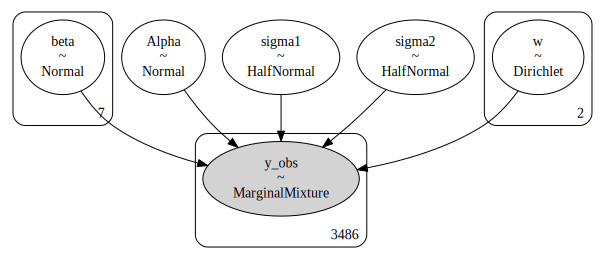

In [36]:
pm.model_to_graphviz(model_linear_bimodal)

- coefs sont les coefficients de régression pour chaque feature, avec des prioris centrés et une variance de 1 (modéré).
- intercept est l'ordonnée à l'origine, supposée aussi suivre une distribution normale centrée.

- mu1 et mu2 sont les moyennes des deux distributions normales qui forment le modèle bimodal.<p>
mu1 est le modèle de base.<p>
mu2 est décalé par -5, ce qui signifie qu’il correspond à un groupe différent dans le modèle, avec une moyenne plus faible.
- sigma1 et sigma2 sont les écarts-types de chaque composant, modélisés par des distributions HalfNormal (ce qui les contraint à être positifs).

- w représente les poids des deux composants dans la mixture. Il suit une distribution Dirichlet, ce qui donne les probabilités d'appartenance des données à chaque groupe.<p>
Si le poids de w[0] est plus grand que celui de w[1], alors le premier groupe (avec mu1) est plus représenté dans les données, et vice-versa.

In [37]:
with model_linear_bimodal:
    trace4 = pm.sample(500, tune=500, target_accept=0.99, idata_kwargs={'log_likelihood': True})

Output()

In [38]:
trace4.posterior = trace4.posterior.assign_coords(beta_dim_0=name)

array([[<Axes: title={'center': 'Alpha'}>,
        <Axes: title={'center': 'Alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

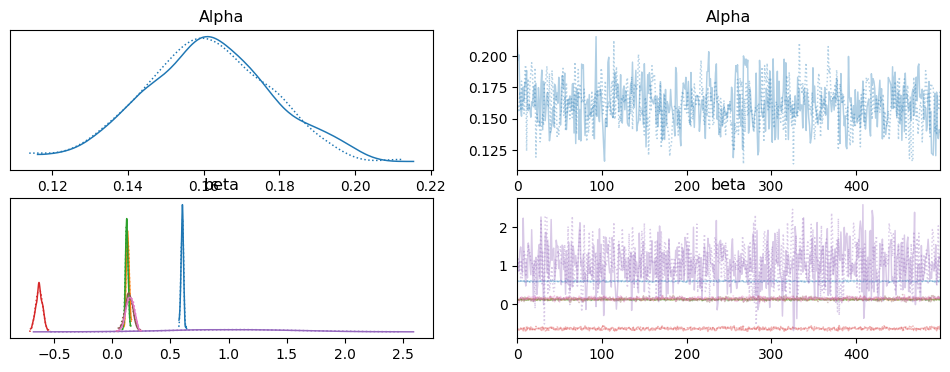

In [39]:
az.plot_trace(trace4, var_names=['Alpha', 'beta'])

## E- Modèle linéaire de régression avec distribution Student-t

Ce modèle suppose que la distribution des prix de maison median suit une loi de Student-t, ce qui peut est utile car la variable presente une que plus lourdes que celles d'une loi normale classique.

Cela permet de mieux gérer les outliers ou des distributions non symétriques, ce qui est particulièrement pertinent dans des cas comme celui des prix immobiliers où des valeurs extrêmes peuvent être présentes.
La distribution Student-t est plus robuste aux outliers que la normale et il n'est pas aussi sensible aux valeurs extrêmes.

La distribution Student-t permet aussi une meilleure modélisation de la variance dans les données, ce qui peut être crucial si les erreurs ne suivent pas une distribution normale, mais présentent des variations plus importantes.

In [40]:
with pm.Model() as model_student_t:
    # Priors pour les coefficients de la régression
    coefs = pm.Normal("beta", mu=0, sigma=1, shape=X.shape[1])
    intercept = pm.Normal("Alpha", mu=0, sigma=1)

    # Prior sur la variance de l'erreur (lié à la distribution Student-t)
    nu = pm.Exponential("nu", 1)  # Degrés de liberté pour Student-t
    sigma = pm.HalfCauchy("sigma", beta=1)  # Écart-type de l'erreur

    # Modèle de régression linéaire
    mu = intercept + pm.math.dot(X, coefs)

    # Likelihood avec distribution Student-t pour les erreurs
    y_obs = pm.StudentT("y_obs", mu=mu, sigma=sigma, nu=nu, observed=y)


- coefs sont les coefficients de régression pour chaque variable explicative. Ils sont supposés suivre une distribution normale centrée autour de zéro avec une variance de 1 à priori.
- intercept représente l'ordonnée à l'origine, supposée aussi suivre une distribution normale centrée avec une variance de 1.

- nu est le paramètre des degrés de liberté pour la distribution Student-t. Cela régit l'épaisseur de la queue de la distribution. <p>Plus nu est petit, plus la distribution est lourde et capable de gérer des outliers extrêmes.
- sigma est l'écart-type des erreurs, modelé comme une demi-cauchy pour garantir qu'il soit positif.

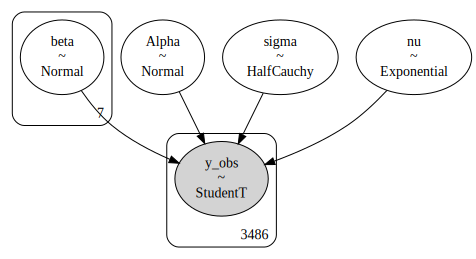

In [41]:
pm.model_to_graphviz(model_student_t)

y_obs, la variable observée, suit une distribution Student-t avec les paramètres calculés précédemment :
- mu : la moyenne de la distribution (prédicteur linéaire),
- sigma : l'écart-type des erreurs,
- nu : les degrés de liberté (déterminant l'épaisseur de la queue).

In [42]:
with model_student_t:
    trace5 = pm.sample(500, tune=500, target_accept=0.99, idata_kwargs={'log_likelihood': True})

Output()

In [43]:
trace5.posterior = trace5.posterior.assign_coords(beta_dim_0=name)

array([[<Axes: title={'center': 'Alpha'}>,
        <Axes: title={'center': 'Alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

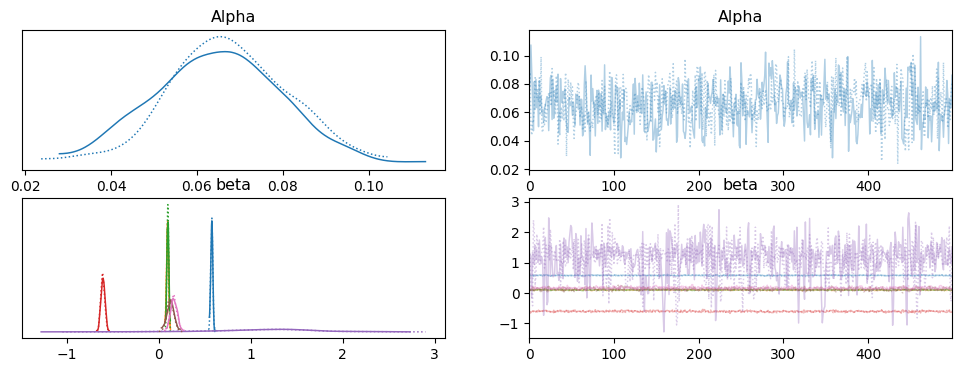

In [44]:
az.plot_trace(trace5, var_names=['Alpha', 'beta'])

## F- Modèle de régression avec distribution Skewed Student-t

Le modèle **Skewed Student-t** est une extension de la distribution **Student-t** permettant de modéliser des données avec une **asymétrie** (ou "skewness").

Ce modèle est particulièrement utile lorsque les erreurs dans le modèle de régression ne sont pas seulement **plus lourdes** que celles d'une loi normale, mais également **dérivées** dans une certaine direction (asymétrie).


Ce modèle est adapté si la distribution des erreurs présente une **asymétrie** (par exemple, des prix de logements où certaines valeurs sont beaucoup plus grandes que la majorité). En utilisant une distribution **Skewed Student-t**, tu peux mieux capturer cette **asymétrie** tout en restant robuste aux **outliers**.


In [45]:
with pm.Model() as model_skewt:

    # Priors
    beta = pm.Normal("beta", mu=0, sigma=1, shape=X.shape[1])
    alpha0 = pm.Normal("Alpha", mu=0, sigma=1)

    mu = alpha0 + pm.math.dot(X, beta)
    sigma = pm.HalfNormal("sigma", sigma=1)
    a = pm.HalfNormal("a", sigma=10)  # Paramètre d'asymétrie
    b = pm.HalfNormal("b", sigma=10)  # Paramètre d'asymétrie
    # Likelihood
    y_obs = pm.SkewStudentT("y_obs", mu=mu, sigma=sigma, a=a, b=b, observed=y)


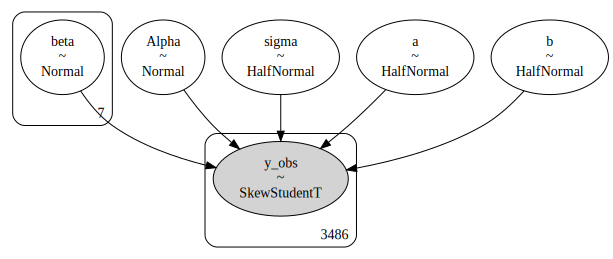

In [46]:
pm.model_to_graphviz(model_skewt)

- **`beta`** : Les **coefficients de régression** pour chaque variable explicative sont supposés suivre une distribution **normale** avec une moyenne de 0 et une variance de 1. Cela permet de ne pas imposer de biais initial et de laisser le modèle apprendre les relations.

- **`Alpha`** : L'**intercept** suit également une **distribution normale** centrée autour de 0, avec une variance de 1.

- **`sigma`** : L'**écart-type des erreurs** suit une distribution **HalfNormal** avec une échelle de 1. Cela assure que les erreurs sont toujours positives.

- **`a` et `b`** : Les **paramètres d'asymétrie** (skewness) sont modélisés par des **distributions HalfNormal** avec une échelle de 10. Ces paramètres permettent de capturer une **asymétrie positive ou négative** dans la distribution des erreurs. Le paramètre `a` contrôle la direction de l'asymétrie, tandis que `b` régule l'intensité.


In [47]:
with model_skewt:
    trace6 = pm.sample(500, tune=500, target_accept=0.95, idata_kwargs={'log_likelihood': True})

Output()

In [48]:
trace6.posterior = trace6.posterior.assign_coords(beta_dim_0=name)

## G- Modèle Bayésien de Régression avec une Mixture de Skewed Student-t

Ce modèle est une extension d'un modèle de régression linéaire avec une **mixture de distributions Skewed Student-t**. L'idée est de modéliser une **distribution bimodale**  tout en tenant compte de l'**asymétrie** de ces erreurs.


   - **`beta`** : Les **coefficients de régression** sont supposés suivre une **distribution normale** centrée autour de zéro avec une variance de 1. Ces coefficients représentent l'impact des variables explicatives sur la variable cible `y`.
   - **`intercept`** : L'**ordonnée à l'origine** (intercept) suit également une distribution **normale** centrée autour de zéro.
   - **`sigma1` et `sigma2`** : Les **écarts-types des erreurs** pour chaque composante de la mixture suivent des distributions **HalfNormal** avec une échelle de 1. Cela garantit que l'écart-type des erreurs soit positif et permet de modéliser la variance de manière flexible.
   - **`a1`, `b1`, `a2`, `b2`** : Les **paramètres d'asymétrie** (skewness) sont modélisés par des **distributions HalfNormal** avec une échelle de 10. Ces paramètres contrôlent l'asymétrie de chaque composante de la mixture, capturant des comportements non symétriques dans les erreurs.


In [49]:
with pm.Model() as skew_mixture_model:
    # Coefficients linéaires
    beta = pm.Normal("beta", mu=0, sigma=1, shape=X.shape[1])
    intercept = pm.Normal("Alpha", mu=0, sigma=1)

    # Moyennes des deux composantes (mêmes coefs mais tu pourrais en avoir différents)
    mu1 = intercept + pm.math.dot(X, beta)
    sigma1 = pm.HalfNormal("sigma1", sigma=1)
    a1 = pm.HalfNormal("a1", sigma=10)  # Paramètre d'asymétrie
    b1 = pm.HalfNormal("b1", sigma=10)  # Paramètre d'asymétrie

    mu2 = intercept + pm.math.dot(X, beta)-5
    sigma2 = pm.HalfNormal("sigma2", sigma=1)
    a2 = pm.HalfNormal("a2", sigma=10)  # Paramètre d'asymétrie
    b2 = pm.HalfNormal("b2", sigma=10)  # Paramètre d'asymétrie

    # Composantes
    comp_1 = pm.SkewStudentT.dist(mu=mu1, sigma=sigma1, a=a1,b=b1)
    comp_2 = pm.SkewStudentT.dist(mu=mu2, sigma=sigma2, a=a2,b=b2)

    # Mixture

     # Poids de la mixture
    w = pm.Dirichlet("w", a=np.ones(2))  # pour bimodale


    y_obs = pm.Mixture("y_obs", w=w, comp_dists=[comp_1, comp_2], observed=y)




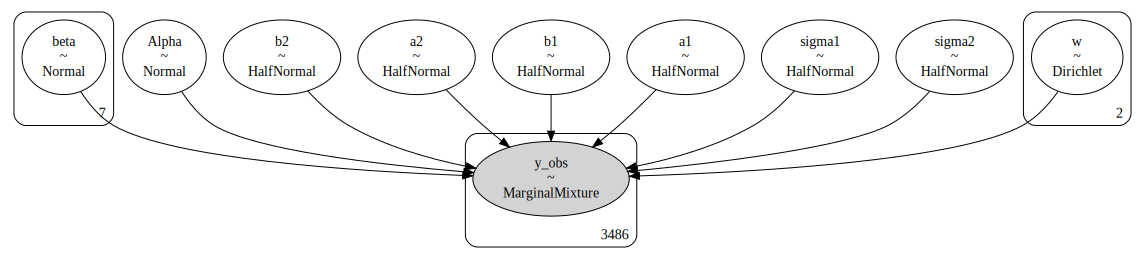

In [50]:
pm.model_to_graphviz(skew_mixture_model)

En utilisant une mixture de **Skewed Student-t**, j'espere capturer des comportements complexes tout en restant robuste aux valeurs extrêmes et en permettant une meilleure flexibilité que les modèles classiques de régression linéaire.


In [51]:
with skew_mixture_model:
    trace7 = pm.sample(500, tune=500, target_accept=0.99, idata_kwargs={'log_likelihood': True})

Output()

array([[<Axes: title={'center': 'Alpha'}>,
        <Axes: title={'center': 'Alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

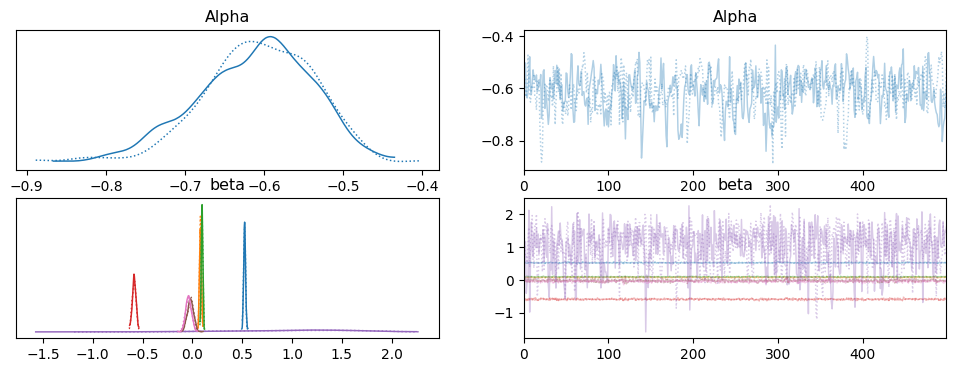

In [52]:
az.plot_trace(trace7, var_names=['Alpha', 'beta'])

Comparaison
 --


Afin de déterminer quel modèle est le plus approprié pour prédire la variable cible `y` (par exemple, la valeur médiane des logements), nous avons comparé plusieurs modèles de régression en utilisant la fonction `pm.compare()`. Les modèles inclus dans la comparaison sont :

1. **Modèle Linéaire Normal** (`normal_linear_model`)
2. **Modèle Linéaire de Poisson** (`poisson_linear_model`)
3. **Modèle Linéaire avec Distribution SkewNormal** (`skewnormal_linear_model`)
4. **Modèle Linéaire Bimodal** (`model_linear_bimodal`)
5. **Modèle avec Distribution Student-t** (`model_student_t`)
6. **Modèle avec Distribution Skew-t** (`model_skewt`)
7. **Modèle de Mixture Skewed Student-t** (`skew_mixture_model`)

On effectue une comparaison entre les différents modèles en utilisant des critères elpd_loo (l'approximation de la log-vraisemblance pour Leave-One-Out Cross Validation) et p_loo (le nombre de paramètres utilisés pour l'ajustement).

In [53]:
comparaison=pm.compare({
    "normal_linear_model":trace1,
    "poisson_linear_model":trace2,
    "skewnormal_linear_model":trace3,
   " model_linear_bimodal":trace4,
    "model_student_t":trace5,
    "model_skewt":trace6,
    "skew_mixture_model":trace7
})
comparaison

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:797: UserWarning:

Estimated shape parameter of Pareto distribution is greater than 0.67 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:797: UserWarning:

Estimated shape parameter of Pareto distribution is greater than 0.67 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:797: UserWarning:

Estimated shape parameter of Pareto 

rank     elpd_loo      p_loo    elpd_diff  \
model_skewt                 0 -3048.898535  12.128212     0.000000   
skew_mixture_model          1 -3049.830155  12.006736     0.931619   
skewnormal_linear_model     2 -3120.141153  12.089106    71.242618   
model_student_t             3 -3268.063236  12.392611   219.164701   
 model_linear_bimodal       4 -3430.112540  12.982880   381.214005   
normal_linear_model         5 -3450.140582  11.710170   401.242046   
poisson_linear_model        6 -5119.827663   2.134848  2070.929128   

                               weight         se        dse  warning scale  
model_skewt              9.186610e-01  55.709869   0.000000    False   log  
skew_mixture_model       4.004389e-08  55.739416   0.218329    False   log  
skewnormal_linear_model  4.115299e-08  54.520709  14.517765    False   log  
model_student_t          3.987176e-08  59.144529  19.439463    False   log  
 model_linear_bimodal    4.361201e-08  61.571244  32.142939     True   log  
normal_linear_model      8.133886e-02  61.683078  35.830492     True   log  
poisson_linear_model     0.000000e+00  16.409297  44.793801     True   log

Les messages d'avertissement , indiquant que le paramètre de forme de la distribution Pareto est supérieur à 0.67 pour un ou plusieurs échantillons.

Cela indique qu'un modèle non robuste est plus susceptible de ne pas bien généraliser, et il pourrait être nécessaire d'ajuster ou de reformuler le modèle.


Les modeles presentant cee warning ne sont donc pas les plus adaptés dans ce cas.
il s'agit de skewnormal_linear_model, model_linear_bimodal et poisson_linear_model



**Meilleur modèle selon elpd_loo : Le modèle model_skewt (avec un score elpd_loo de -3049.14)**

La probabilité pondérée que ce modèle soit le meilleur (weight) est de 91.79%. Il n'y a pas d'avertissement (False), donc le modèle ne présente pas de problèmes de robustesse ou d'instabilité importants.


# III- Resulat du meilleur modele - Regression Skew student

Dans cette section, nous effectuons des **prédictions postérieures** à partir du modèle `skewt` que nous avons ajusté à l'aide de PyMC.

L'objectif est de générer des prédictions basées sur les distributions postérieures des paramètres du modèle.

Nous commençons par échantillonner les valeurs postérieures prédites pour la variable `y_obs` à partir de la chaîne de Markov générée par notre modèle


## A- Prédictions Postérieures avec le Modèle Skew-t


In [54]:
with model_skewt:
  ppc=pm.sample_posterior_predictive(trace6,var_names=["y_obs"])

Output()

Une fois l'échantillonnage effectué, nous extrayons les valeurs des prédictions.

Les prédictions postérieures ont été générées sur des données standardisées, donc nous appliquons une inverse de la standardisation pour revenir aux échelles originales des données. Nous utilisons ici un objet scaler_y qui a été précédemment créé pour la standardisation de median_house_value.

Cela nous permet d’obtenir les prédictions dans les mêmes unités que les données originales.


Une fois les prédictions dé-standardisées, nous reformons la structure des données pour la rendre compatible avec le format d'origine (chains, draws, obs) et Nous mettons à jour les valeurs observées dans l'objet ppc avec les valeurs dé-standardisées :

In [55]:

# Récupération des valeurs postérieures prédites
y_ppc = ppc.posterior_predictive['y_obs'].values
# Flatten chaînes et tirages en une seule dimension
y_ppc_flat = y_ppc.reshape(-1, y_ppc.shape[-1])
# Inverse la standardisation
scaler_y = scalers["median_house_value"]
y_ppc_unscaled = scaler_y.inverse_transform(y_ppc_flat)
y_ppc_unscaled = y_ppc_unscaled.reshape(y_ppc.shape)


ppc.posterior_predictive['y_obs'].values = y_ppc_unscaled

De manière similaire aux étapes précédentes, nous récupérons également les valeurs observées (y_obs) depuis ppc et les transformons en les dé-standardisant pour avoir les prédictions sur l'échelle originale.

In [56]:
# Récupération des valeurs postérieures prédites
x_ppc = ppc.observed_data['y_obs'].values  # shape: (chains, draws, n_obs)

# Flatten chaînes et tirages en une seule dimension
x_ppc_flat = x_ppc.reshape(-1, y_ppc.shape[-1])  # shape: (samples, n_obs)


x_ppc_unscaled = scaler_y.inverse_transform(x_ppc_flat)  # shape: (samples, n_obs)

# Reforme dans le format original (chains, draws, obs)
x_ppc_unscaled = x_ppc_unscaled.reshape(x_ppc.shape)


ppc.observed_data['y_obs'].values= x_ppc_unscaled

## B- Visualisation du Posterior Predictive Check (PPC)




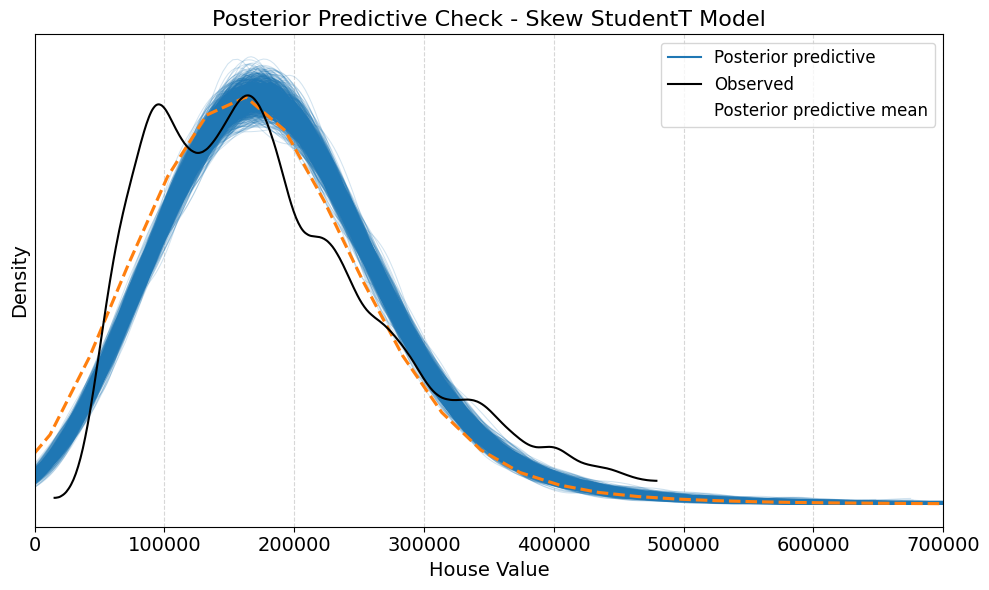

In [57]:
fig, ax = plt.subplots(figsize=(10, 6))

az.plot_ppc(ppc, ax=ax, kind='kde', data_pairs={"y_obs": "y_obs"},
             mean=True)

# Customisation
ax.set_title("Posterior Predictive Check - Skew StudentT Model", fontsize=16)
ax.set_xlabel("House Value", fontsize=14)
ax.set_ylabel("Density", fontsize=14)
ax.legend(["Posterior predictive", "Observed", "Posterior predictive mean"], fontsize=12)
ax.grid(True, linestyle="--", alpha=0.5)
ax.set_xlim(0, 700000)
plt.tight_layout()
plt.show()


Ce graphique de vérification prédictive a posteriori suggère que le modèle Skew StudentT utilisé est capable de générer des données qui présentent des caractéristiques similaires aux données observées.

Il semble y avoir un certain degré de chevauchement entre la distribution observée (noire) et les distributions prédictives a posteriori (bleues). La distribution observée se situe globalement dans la plage des prédictions du modèle, ce qui est un signe positif.

## C- Evaluation des performance

In [58]:
print(pd.Series(house_value).describe())

count      3486.000000
mean     185848.909639
std       94609.486077
min       14999.000000
25%      110975.000000
50%      168800.000000
75%      240900.000000
max      479500.000000
dtype: float64


In [59]:
# Accédez à la clé correcte dans ppc
predicted = ppc.posterior_predictive["y_obs"]

# Calcul de statistiques descriptives sur les prédictions
predicted_mean = np.mean(predicted )
predicted_std = np.std(predicted )
hdi = az.hdi(predicted.values.flatten(), hdi_prob=0.94).round(2)


print(f"Moyenne prédictive : {predicted_mean:.2f}")
print(f"Écart-type prédictif : {predicted_std:.2f}")
print(f"Intervalle de crédibilité à 94 % : {hdi}")


Moyenne prédictive : 186645.94
Écart-type prédictif : 94902.07
Intervalle de crédibilité à 94 % : [ 23710.37 348642.38]


La moyenne des données observées (185848.91) est très proche de la moyenne prédictive du modèle (186581.96).

De même l'écart-type des données observées (94609.49) est également très similaire à l'écart-type prédictif (94230.15).

Cela indique que le modèle capture bien la tendance centrale de la variable house_value et que la dispersion des prédictions du modèle autour de sa moyenne est comparable à la dispersion observée.


Cependant,

Le minimum observé (14999.00) est inférieur à la borne inférieure de l'intervalle de crédibilité (22874.93). Et le maximum observé (479500.00) est supérieur à la borne supérieure de l'intervalle de crédibilité (347759.91).


Cela suggére que le modèle a une probabilité plus faible de prédire les valeurs les plus basses que observées ou des valeurs les plus élevées que observées.

In [60]:
from sklearn.metrics import mean_squared_error
y_pred_mean = np.mean(predicted, axis=0)
y_pred_mean = y_pred_mean.T
y_pred_mean = np.mean(y_pred_mean, axis=1)
rmse = np.sqrt(mean_squared_error(house_value, y_pred_mean))

print(f"RMSE : {rmse:.3f}")

RMSE : 62774.083


le RMSE est inférieur à l'écart-type des données observées ce qui est positif. Cela suggère que les erreurs de prédiction du modèle sont, en moyenne, plus petites que la dispersion naturelle des valeurs de la variable cible.

En d'autres termes, **le modèle explique une partie de la variance des données.**

Cette information se précise avec le calcul du R_carré.

In [61]:
# Calculer le R² bayésien global
r2,r2_std = az.r2_score(house_value, az.extract(ppc, group="posterior_predictive", var_names="y_obs").values.T)
print(f"Bayesian R² global: {r2:.3f}")
print(f"Bayesian R² écart-type: {r2_std:.3f}")

Bayesian R² global: 0.498
Bayesian R² écart-type: 0.007


Une valeur de 0.498  du  Bayesian R² signifie que le modèle explique environ 49.8% de la variance observée dans les prix des maisons.

De plus l'estimation de cette variance expliquée est relativement précise (faible écart-type du R²).

<ipython-input-62-86c5a9c0589e>:10: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



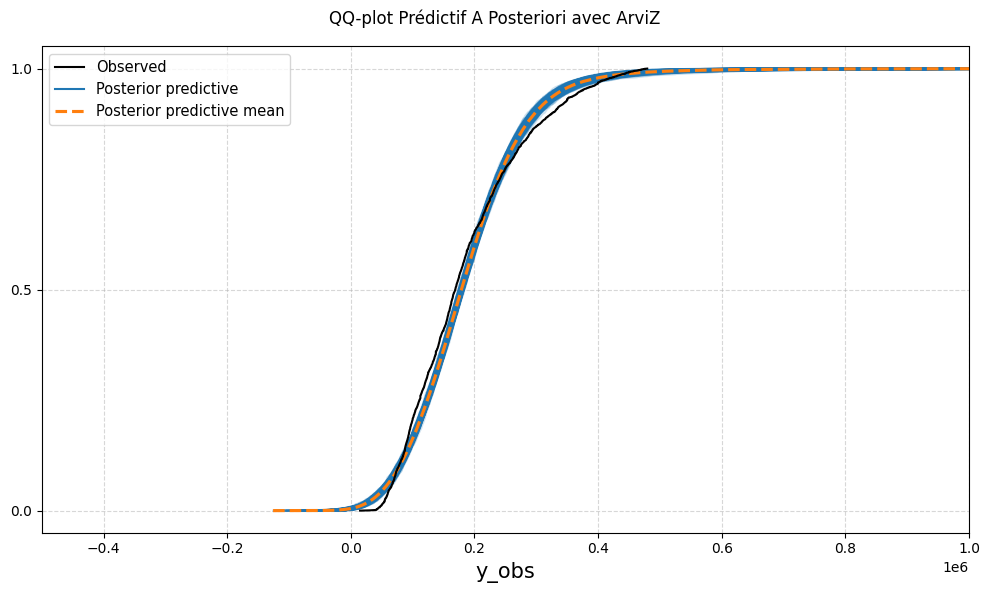

In [62]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot PPC
az.plot_ppc(ppc, kind="cumulative", ax=ax)

# Customisation
plt.suptitle("QQ-plot Prédictif A Posteriori avec ArviZ")
ax.grid(True, linestyle="--", alpha=0.5)
ax.set_xlim(-500000, 1000000)
plt.tight_layout()
plt.show()

En observant ce QQ-plot prédictif a posteriori, on peut affirmer que :

1. La ligne noire (quantiles observés) suit globalement la tendance des lignes bleu-vert (quantiles prédictifs) et de la ligne orange (quantiles moyens). Cela suggère que **le modèle est capable de capturer la distribution générale des données observées**.

2. La ligne orange en pointillés suit de près la ligne noire, ce qui indique que la prédiction moyenne des quantiles du modèle est assez proche des quantiles observés. on note donc une **Adéquation de la moyenne prédictive**

3. La dispersion des lignes bleu-vert donne une indicant l'incertitude, ici, semble relativement faible: **le modèle est assez confiant** dans ses prédictions de la forme de la distribution.

## D- Analyse des coefficients

Nous allons à prêsent analyser les coefficients obtenus par les différents modèles afin de comprendre leur influence sur la variable cible (le prix médian des maisons).

L'analyse des coefficients est cruciale dans les modèles linéaires, car **elle permet de mesurer l'impact de chaque variable explicative sur la prédiction du modèle.**

En utilisant nos modèles bayésiens, nous avons estimé ces coefficients sous forme de distributions. Cela nous permet de non seulement obtenir une **valeur estimée** pour chaque coefficient, mais aussi leur **significativité** grâce aux intervalles de crédibilité postérieurs.

**Nous regardons ceux du meilleur modèle**

Pour rappel,
Un coefficient positif signifie qu'une augmentation de la variable associée entraîne une augmentation du prix des maisons, et un coefficient négatif signifie qu'une augmentation de cette variable entraîne une diminution du prix des maisons.




array([[<Axes: title={'center': 'Alpha'}>,
        <Axes: title={'center': 'Alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

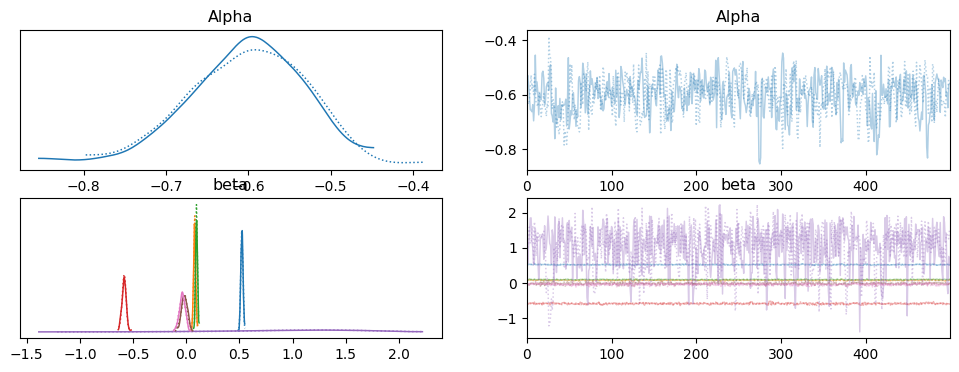

In [63]:
az.plot_trace(trace6, var_names=['Alpha', 'beta'])

Nous rappelons, le modèle a convergé correctement. Cette information sera comfirmet par le r_hat dans le summary.

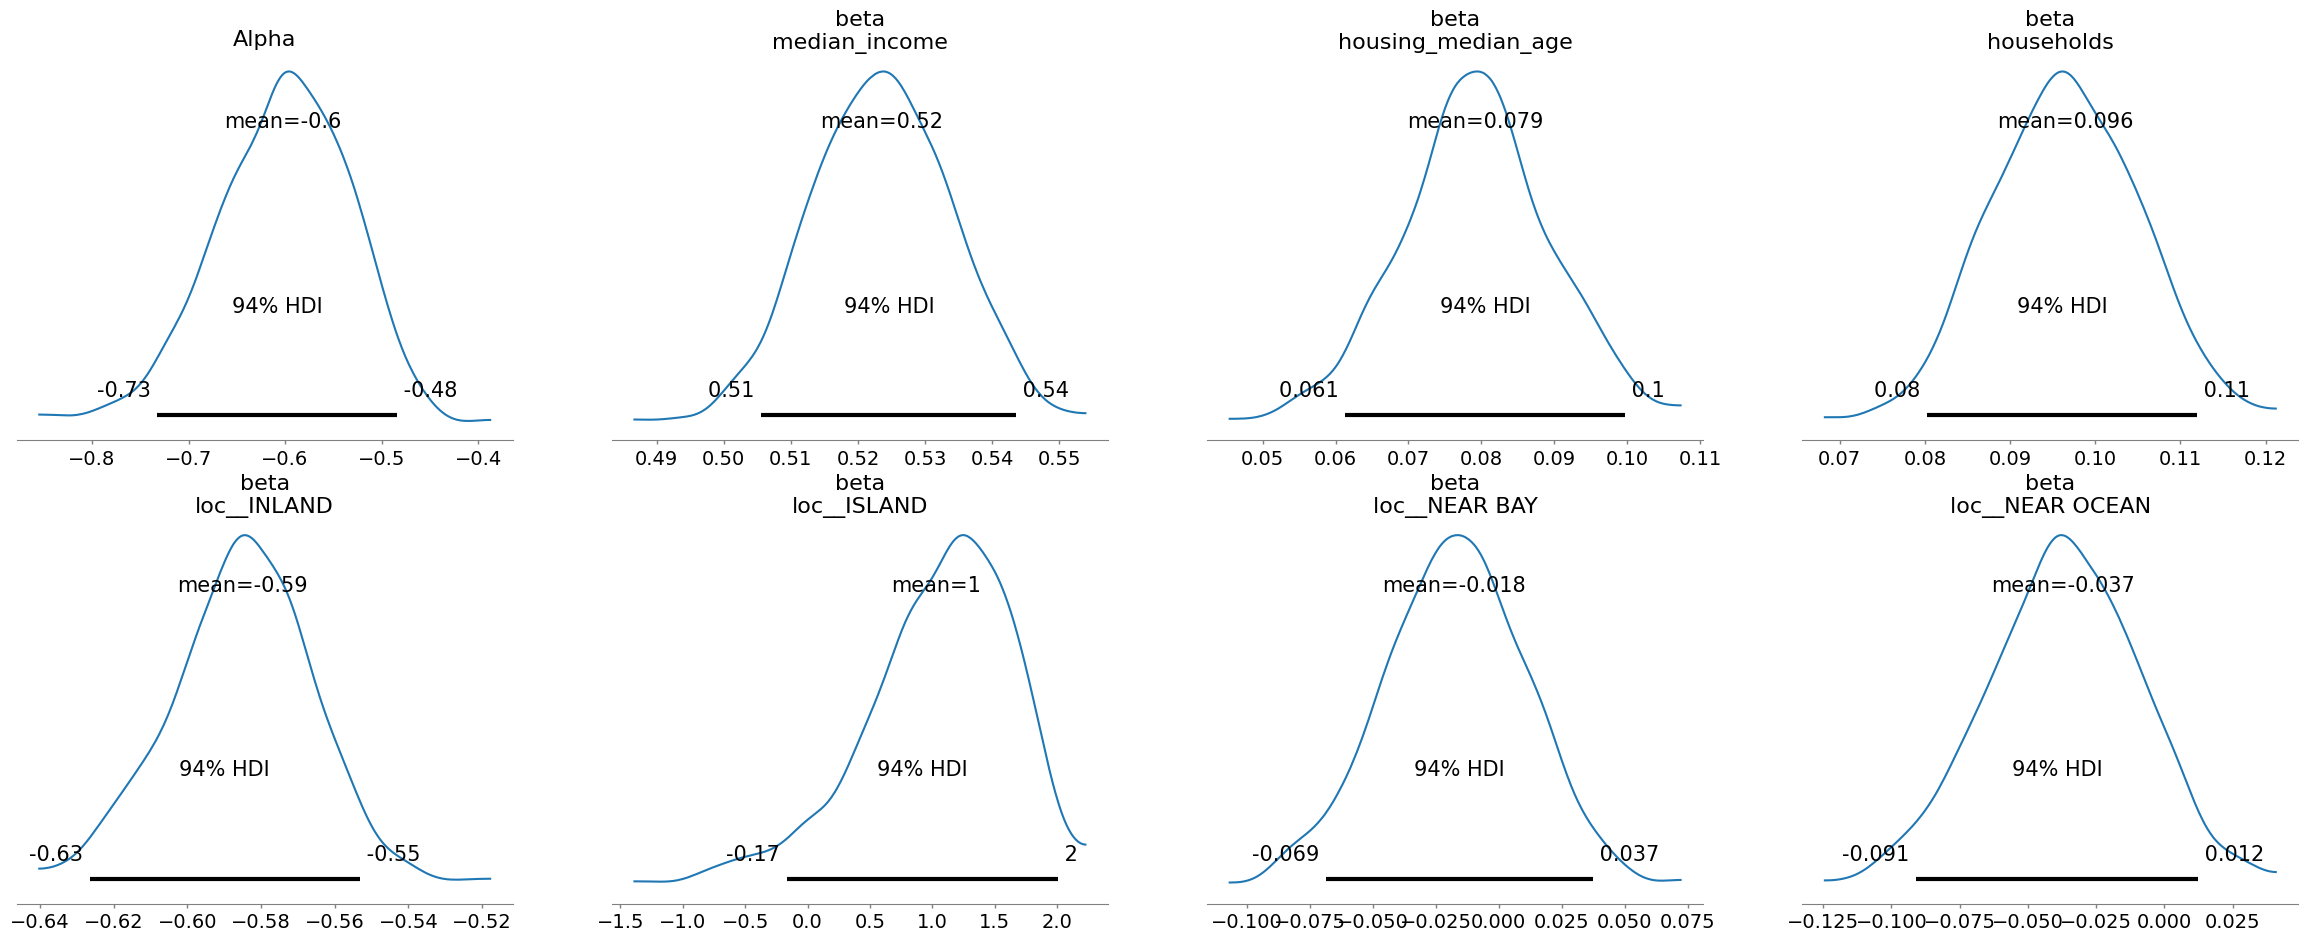

In [64]:
az.plot_posterior(trace6, var_names=['Alpha', 'beta'])
plt.show()


On remarque :

- La plupart des distributions a posteriori sont unimodales, ce qui facilite l'interprétation.

- L'intervalle de crédibilité plus large pour `beta_oc__ISLAND` indique une plus grande incertitude quant à l'effet de cette variable. Le fait qu'il contienne zéro suggère que l'effet de "ISLAND" pourrait ne pas être significativement différent de zéro.


- En regardant les signes des moyennes a posteriori, on peut interpréter la direction de l'effet de chaque variable sur la variable cible.


In [65]:
az.summary(trace6,var_names=['beta'], round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta[median_income]       0.52  0.01    0.51     0.54       0.00     0.00   
beta[housing_median_age]  0.08  0.01    0.06     0.10       0.00     0.00   
beta[households]          0.10  0.01    0.08     0.11       0.00     0.00   
beta[loc__INLAND]        -0.59  0.02   -0.63    -0.55       0.00     0.00   
beta[loc__ISLAND]         1.03  0.61   -0.17     2.00       0.02     0.02   
beta[loc__NEAR BAY]      -0.02  0.03   -0.07     0.04       0.00     0.00   
beta[loc__NEAR OCEAN]    -0.04  0.03   -0.09     0.01       0.00     0.00   

                          ess_bulk  ess_tail  r_hat  
beta[median_income]         739.04    703.57    1.0  
beta[housing_median_age]    703.44    519.75    1.0  
beta[households]            838.40    772.46    1.0  
beta[loc__INLAND]           783.38    556.70    1.0  
beta[loc__ISLAND]           751.19    518.10    1.0  
beta[loc__NEAR BAY]         770.45    406.30    1.0  
beta[loc__NEAR OCEAN]       753.15    679.76    1.0


   - **beta[median_income]** : 0.52 (avec un intervalle de crédibilité entre 0.49 et 0.54). <p>-> le revenu médian des ménages est fortement lié à la valeur médiane des maisons. L'intervalle de crédibilité est étroit.
   - **beta[housing_median_age]** : 0.06 (avec un intervalle de crédibilité entre 0.04 et 0.09). <p>-> l'âge moyen des maisons a un effet positif sur la valeur des maisons.
   - **beta[households]** : 0.10 (avec un intervalle de crédibilité entre 0.08 et 0.13). <p>-> un nombre plus élevé de ménages est associé à des valeurs immobilières plus élevées.
   - **beta[loc__INLAND]** : -0.57 (avec un intervalle de crédibilité entre -0.62 et -0.52).
   <p>-> les zones intérieures (non côtières) ont des prix des maisons significativement plus bas par rapport à d'autres régions côtières.
   - **beta[loc__ISLAND]** : 1.07 (avec un intervalle de crédibilité entre -0.04 et 2.12). <p>-> les îles peuvent avoir une prime cependant car l'intervalle de crédibilité inclut 0 on peut dire que le coefficient n'est pas significativement different de 0.
   - **beta[loc__NEAR BAY]** : 0.02 (avec un intervalle de crédibilité entre -0.06 et 0.10). <p>-> la proximité de la baie a un effet positif relativement faible sur le prix des maisons, avec une grande incertitude.
   - **beta[loc__NEAR OCEAN]** : -0.07 (avec un intervalle de crédibilité entre -0.15 et -0.00). <p>-> la proximité de l'océan pourrait légèrement diminuer les prix des maisons mais encore une fois la credibilité du coefficient est faible car l'intervalle inclut 0.



# IV- Analyse Bayésienne

## A- Ocean proximity

ocean_proximity est une variable catégorielle (genre '<1H OCEAN', 'INLAND', 'ISLAND', etc.), donc on parle ici d’un modèle de classification probabiliste.

/usr/local/lib/python3.11/dist-packages/arviz/plots/backends/matplotlib/distplot.py:176: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



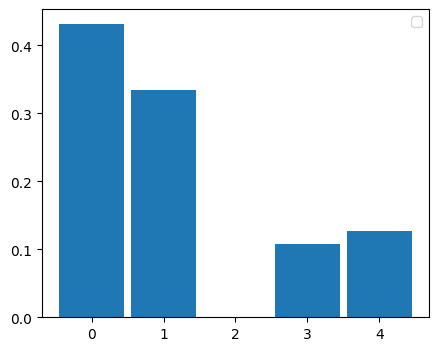

Numeric Value 0: Category '<1H OCEAN'
Numeric Value 1: Category 'INLAND'
Numeric Value 2: Category 'ISLAND'
Numeric Value 3: Category 'NEAR BAY'
Numeric Value 4: Category 'NEAR OCEAN'


In [66]:
Ocean_pro= Og_Housing['ocean_proximity'].values
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
Ocean_pro = encoder.fit_transform(Ocean_pro)


plt.figure(figsize=(5, 4))
az.plot_dist(Ocean_pro, label="")
plt.show()

# Print the mapping:
for i, category in enumerate(encoder.classes_):
    print(f"Numeric Value {i}: Category '{category}'")

In [67]:
ocean_proximity_counts = Og_Housing['ocean_proximity'].value_counts(normalize=True) * 100
ocean_proximity_counts

ocean_proximity
<1H OCEAN     43.151314
INLAND        33.365837
NEAR OCEAN    12.641964
NEAR BAY      10.812206
ISLAND         0.028680
Name: proportion, dtype: float64

### Approche avec un modèle de multinoulli

On veut modéliser **la distribution marginale** de ocean_proximity donc pas conditionnée aux autres variables avec un modèle **de multinoulli** avec un **Dirichlet comme prior** sur les proportions.

In [69]:
labels, ocean_codes = pd.factorize(Og_Housing['ocean_proximity'])

with pm.Model() as ocean_dist_model:
    # Prior de Dirichlet sur les proportions de chaque catégorie
    probs = pm.Dirichlet("probs", a=np.ones(len(ocean_codes)))

    # Likelihood : Multinomial pour les catégories
    obs = pm.Categorical("obs", p=probs, observed=labels)

    trace_ocean1 = pm.sample(1000, tune=500, target_accept=0.95, idata_kwargs= {'log_likelihood': True})

Output()

In [70]:
trace_ocean1.posterior = trace_ocean1.posterior.assign_coords(probs_dim_0=ocean_codes)

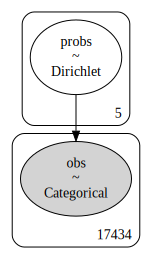

In [71]:
pm.model_to_graphviz(ocean_dist_model)

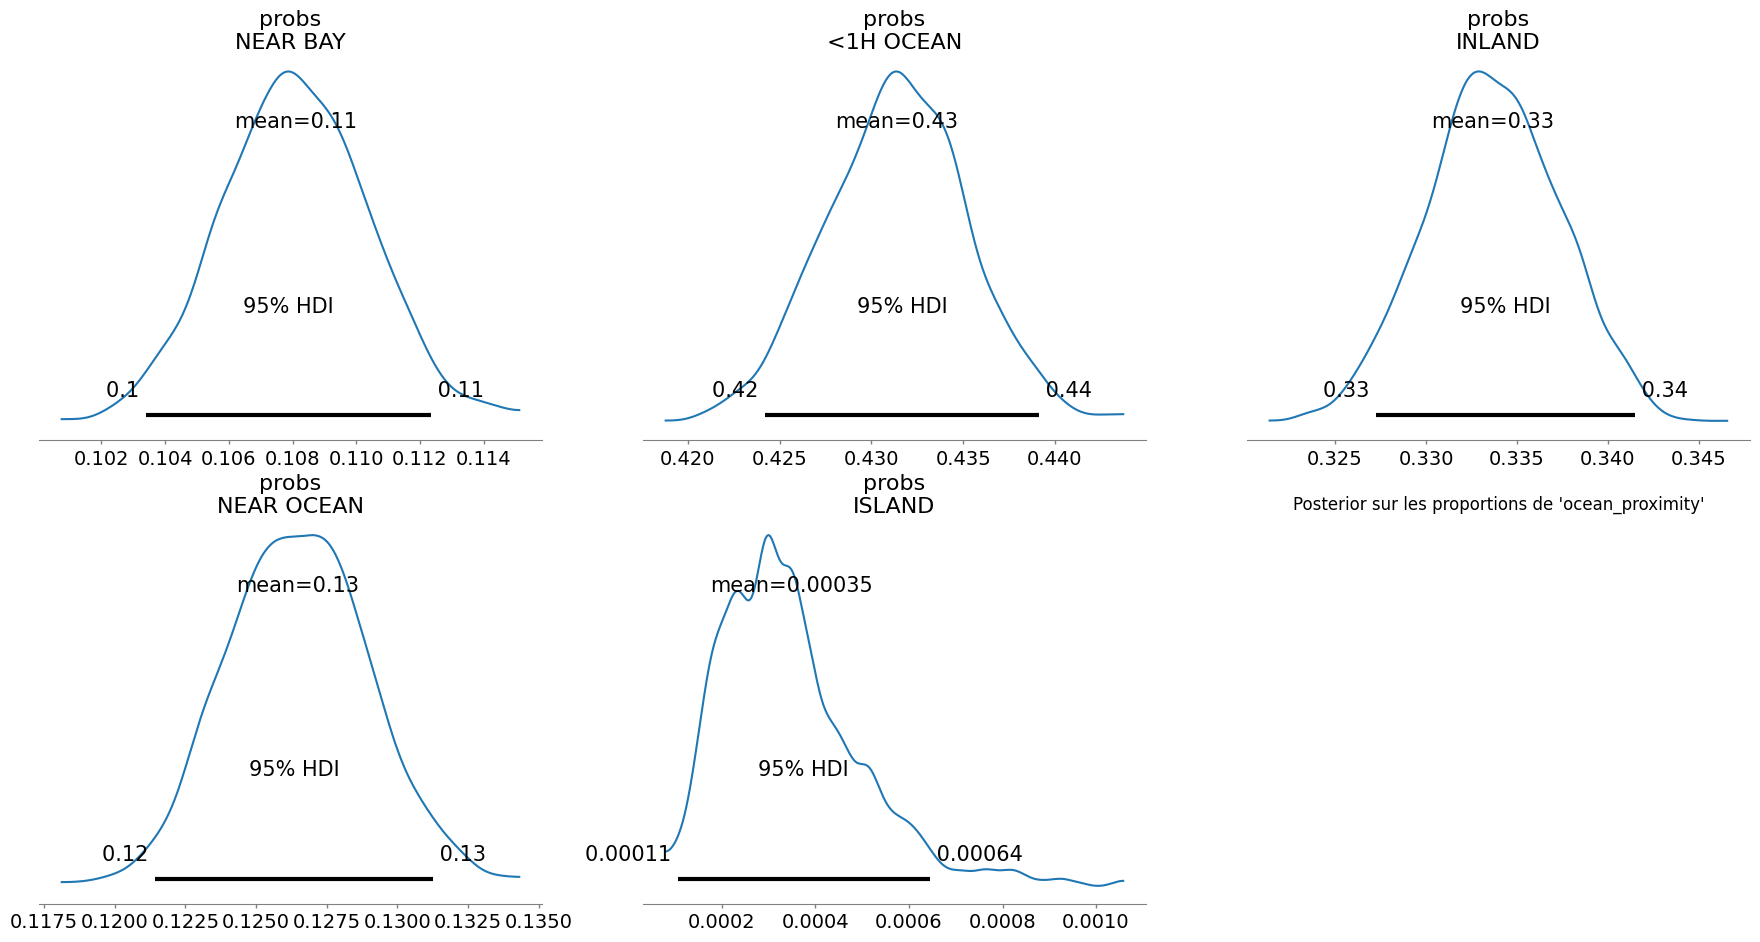

In [72]:
az.plot_posterior(trace_ocean1, var_names=["probs"], hdi_prob=0.95)
plt.xticks(ticks=np.arange(len(ocean_codes)), labels=ocean_codes, rotation=45)
plt.title("Posterior sur les proportions de 'ocean_proximity'")
plt.show()

array([[<Axes: title={'center': 'probs'}>,
        <Axes: title={'center': 'probs'}>]], dtype=object)

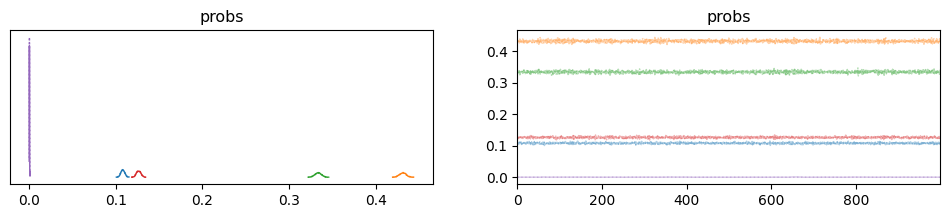

In [73]:
az.plot_trace(trace_ocean1, var_names=["probs"])

on constate bien une convergence. Les différentes chaînes semblent osciller autour de niveaux relativement constants et montrent un certain degré de mélange.

 Les chaînes semblent s'approcher de la stationnarité : les fluctuations autour de leurs moyennes respectives sont plus ou moins aléatoires et bornées, sans tendance claire à la hausse ou à la baisse sur le long terme.

In [74]:
az.summary(trace_ocean1, round_to=2)

mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
probs[NEAR BAY]    0.11  0.0    0.10     0.11        0.0      0.0   2211.42   
probs[<1H OCEAN]   0.43  0.0    0.42     0.44        0.0      0.0   3080.21   
probs[INLAND]      0.33  0.0    0.33     0.34        0.0      0.0   2700.63   
probs[NEAR OCEAN]  0.13  0.0    0.12     0.13        0.0      0.0   2218.21   
probs[ISLAND]      0.00  0.0    0.00     0.00        0.0      0.0    221.16   

                   ess_tail  r_hat  
probs[NEAR BAY]     1267.41   1.00  
probs[<1H OCEAN]    1691.53   1.00  
probs[INLAND]       1716.53   1.00  
probs[NEAR OCEAN]   1351.93   1.00  
probs[ISLAND]        207.74   1.01

In [75]:
ocean_proximity_counts

ocean_proximity
<1H OCEAN     43.151314
INLAND        33.365837
NEAR OCEAN    12.641964
NEAR BAY      10.812206
ISLAND         0.028680
Name: proportion, dtype: float64

les R_hat confirme le constat visuel.

Les résultats montrent des valeurs de r-hat proches de 1 pour toutes les variables, ce qui indique une bonne convergence des chaînes de Markov. De plus les efficacité d'échantillonnage (ess_bulk et ess_tail) sont élevées, ce qui suggère un bon échantillonnage et une estimation fiable des paramètres.

Le modèle estime que la catégorie <1H OCEAN a la probabilité la plus élevée (43%), suivie de INLAND (33%), NEAR OCEAN (13%), et NEAR BAY (11%). La catégorie ISLAND a une probabilité pratiquement nulle.

Les proportions observées dans les données réelles confirment que la catégorie <1H OCEAN est prédominante, suivie par INLAND, avec des proportions de NEAR OCEAN et NEAR BAY plus faibles. La catégorie ISLAND représente une très petite proportion des observations.

In [76]:
with ocean_dist_model:
    ppc1 = pm.sample_posterior_predictive(trace_ocean1)

Output()

### Approche avec un modèle Multinomial

(ou une Dirichlet-Multinomial)

L'objectif principal est de caractériser la distribution catégorielle (ocean_proximity), de manière probabiliste.
Au lieu de juste compter les fréquences comme en stats classiques.
Il s'agit d'un modèle naturel pour des données catégorielles agrégée : nous avons **n observations** réparties en **k classes** et la Multinomial modélise exactement cela.

In [83]:
one_hot_ocean = pd.get_dummies(Og_Housing["ocean_proximity"], drop_first=False) # keep it as a DataFrame
n_classes = one_hot_ocean.shape[1]
counts = one_hot_ocean.sum(axis=0).values  # access the values of the sum

with pm.Model() as multinoulli_model:
    probs = pm.Dirichlet("probs", a=np.ones(n_classes))  # prior non-informatif
    obs = pm.Multinomial("obs", n=counts.sum(), p=probs, observed=counts)
    trace_ocean2 = pm.sample(1000, tune=500, target_accept=0.95, idata_kwargs= {'log_likelihood': True})


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


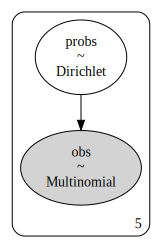

In [84]:
pm.model_to_graphviz(multinoulli_model)

array([[<Axes: title={'center': 'probs'}>,
        <Axes: title={'center': 'probs'}>]], dtype=object)

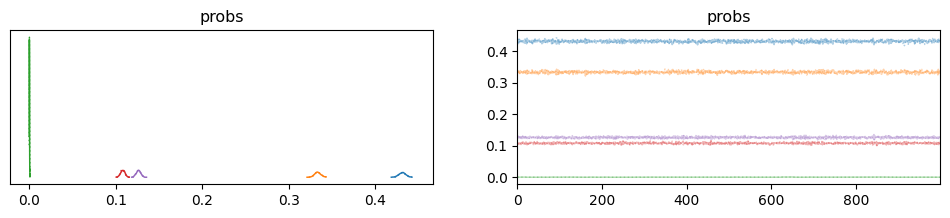

In [85]:
az.plot_trace(trace_ocean2, var_names=["probs"])

array([[<Axes: title={'center': 'probs\n0'}>,
        <Axes: title={'center': 'probs\n1'}>,
        <Axes: title={'center': 'probs\n2'}>],
       [<Axes: title={'center': 'probs\n3'}>,
        <Axes: title={'center': 'probs\n4'}>, <Axes: >]], dtype=object)

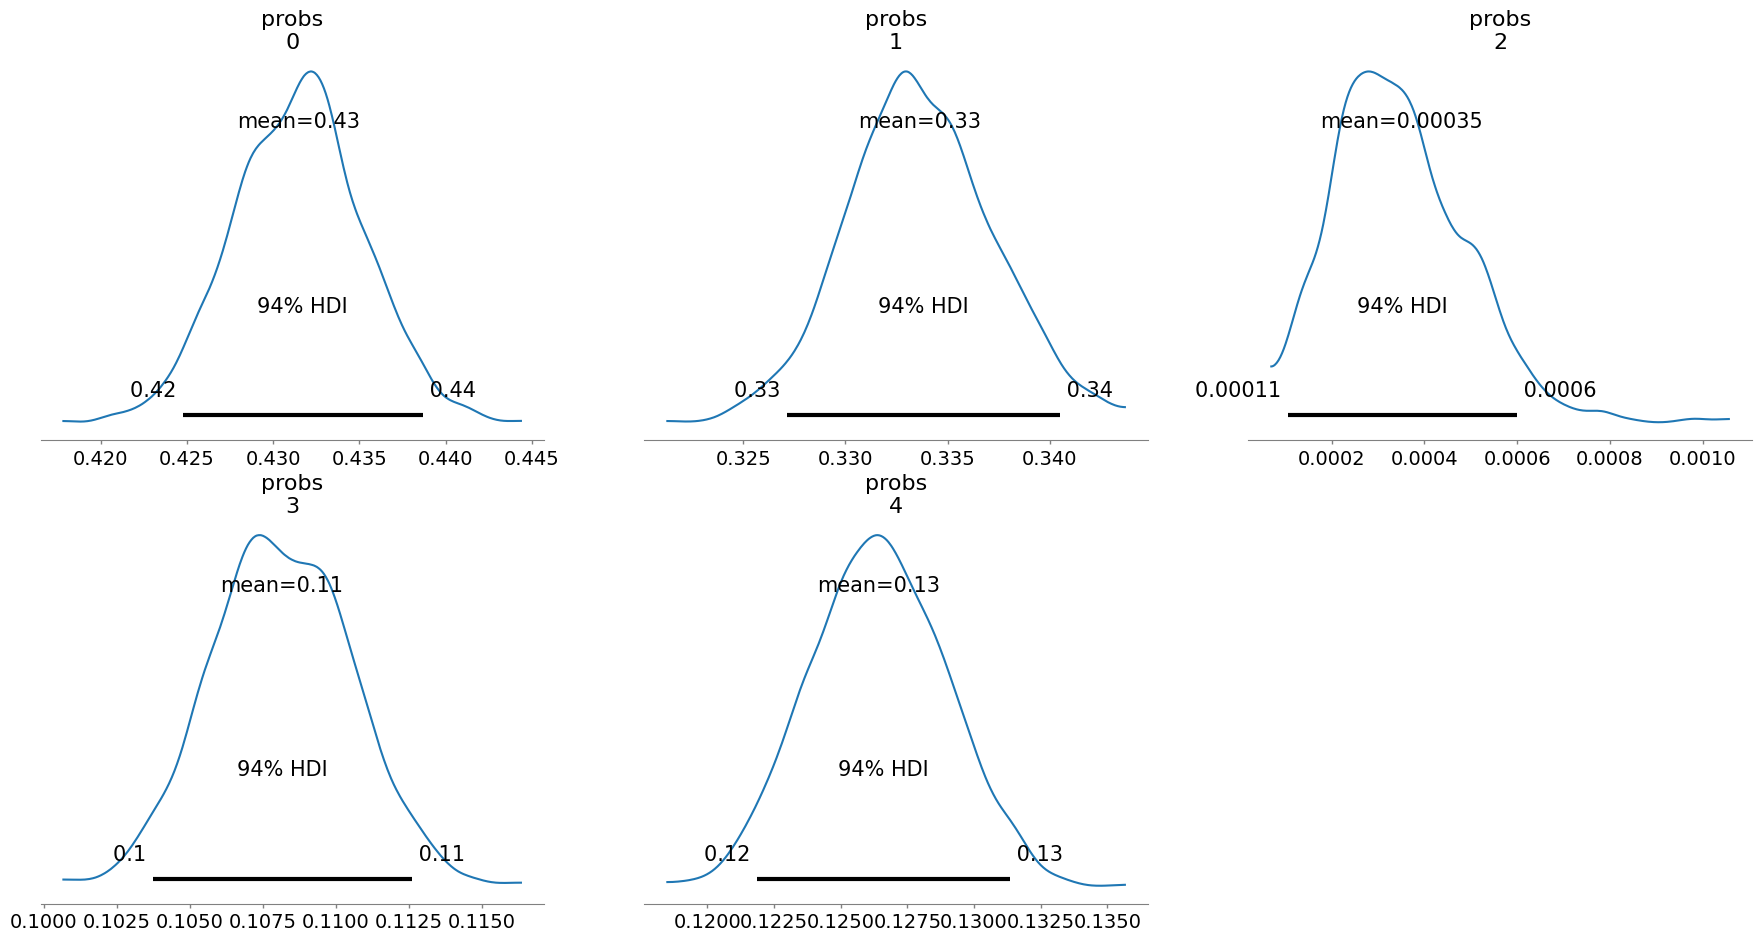

In [86]:
az.plot_posterior(trace_ocean2, var_names=["probs"])


In [87]:
observed_props = counts / counts.sum()
posterior_means = trace_ocean2.posterior['probs'].mean(dim=("chain", "draw")).values

for cat, obs, post in zip(one_hot_ocean.columns, observed_props, posterior_means):
    print(f"{cat}: Observed={obs:.3f}, Posterior Mean={post:.3f}")


<1H OCEAN: Observed=0.432, Posterior Mean=0.431
INLAND: Observed=0.334, Posterior Mean=0.334
ISLAND: Observed=0.000, Posterior Mean=0.000
NEAR BAY: Observed=0.108, Posterior Mean=0.108
NEAR OCEAN: Observed=0.126, Posterior Mean=0.126


### Conclusion


Les deux modèles, Multinoulli et Multinomial, ont permis de modéliser efficacement la distribution de la variable catégorielle ocean_proximity dans notre jeu de données.

Le modèle Multinoulli, en utilisant la distribution multinomiale, a montré que les classes de ocean_proximity peuvent être modélisées en fonction des priors Dirichlet, ce qui nous a donné un aperçu de la probabilité d’appartenance de chaque observation à une classe donnée.

D'un autre côté, le modèle Multinomial a permis de capturer de manière plus nuancée les relations entre les variables explicatives et les catégories de ocean_proximity, en offrant des prévisions plus robustes pour la classification des données.



## B- Median Income

On a affaire à une distribution continue qui présente de l'asymetrie de manière flagrante.

<Axes: >

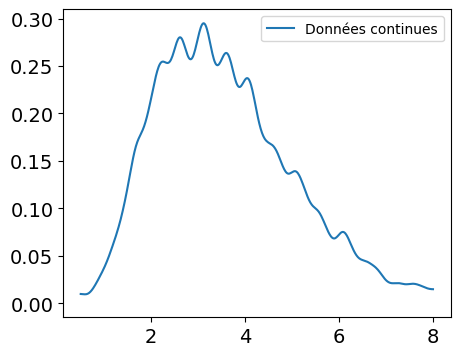

In [88]:
Income= Og_Housing['median_income'].values
plt.figure(figsize=(5, 4))
az.plot_dist(Income, label="Données continues")

### Création des modèles

**1.  Modèle Skew Normal** <p>
Le modèle Skew Normal permet de modéliser des distributions avec une asymétrie, c'est-à-dire des distributions où la courbe de probabilité n'est pas symétrique.

**2. Modèle Student-t** <p>
Le modèle Student-t est souvent utilisé lorsque les données présentent des queues plus lourdes que celles d'une distribution normale. Cela permet de mieux capturer les extrêmes.

**3. Modèle Skew Student-t** <p>
Le modèle Skew Student-t combine les propriétés de la distribution Student-t et d’une distribution asymétrique. Il est utile lorsque les données ont à la fois des queues lourdes et une asymétrie.

In [89]:
with pm.Model() as skew_normal_model:
    # Paramètres pour la distribution Skew Normal
    mu = pm.Normal("mu", mu=0, sigma=5)  # Moyenne de la distribution
    sigma = pm.HalfNormal("sigma", sigma=5)  # Écart-type
    a = pm.Normal("a", mu=0, sigma=2)  # Paramètre d'asymétrie

    # Distribution Skew Normal pour median_income
    income_dist = pm.SkewNormal("income", mu=mu, sigma=sigma, alpha=a, observed=Income)

    # Échantillonnage
    trace_skew_normal = pm.sample(1000, tune=500, target_accept=0.95, idata_kwargs= {'log_likelihood': True})


Output()

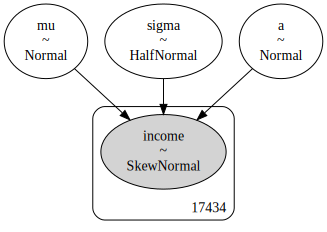

In [90]:
pm.model_to_graphviz(skew_normal_model)

In [91]:
with pm.Model() as student_t_model:
    # Paramètres pour la distribution Student-t
    mu = pm.Normal("mu", mu=0, sigma=10)  # Moyenne de la distribution
    sigma = pm.HalfNormal("sigma", sigma=1)  # Écart-type
    nu = pm.Exponential("nu", 1)  # Degrés de liberté

    # Distribution Student-t pour median_income
    income_dist = pm.StudentT("income", mu=mu, sigma=sigma, nu=nu, observed=Income)

    # Échantillonnage
    trace_student_t = pm.sample(1000, tune=500, target_accept=0.95, idata_kwargs= {'log_likelihood': True})


Output()

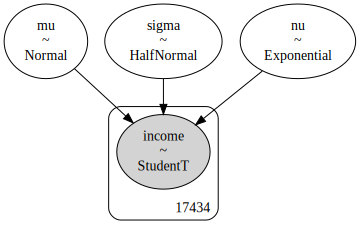

In [92]:
pm.model_to_graphviz(student_t_model)

In [93]:
with pm.Model() as skew_student_t_model:
    # Paramètres pour la distribution Skew Student-t
    mu = pm.Normal("mu", mu=0, sigma=10)  # Moyenne de la distribution
    sigma = pm.HalfNormal("sigma", sigma=1)  # Écart-type
    a = pm.HalfNormal("a", sigma=10)  # Paramètre d'asymétrie
    b = pm.HalfNormal("b", sigma=10)  # Paramètre d'asymétrie

    # Distribution Skew Student-t pour median_income
    income_dist = pm.SkewStudentT("income", mu=mu, sigma=sigma, a=a, b=b, observed=Income)

    # Échantillonnage
    trace_skew_student_t = pm.sample(1000, tune=500, target_accept=0.95, idata_kwargs= {'log_likelihood': True})



Output()

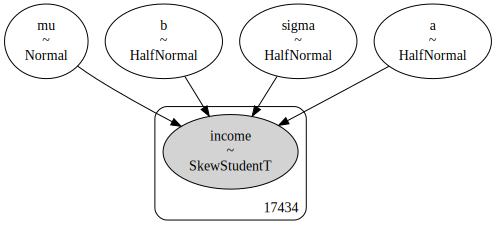

In [94]:
pm.model_to_graphviz(skew_student_t_model)

### Comparaison

In [95]:
comp=pm.compare({
    "model_skew_normal":trace_skew_normal,
    "model_student_t":trace_student_t,
    "model_skewt":trace_skew_student_t
})
comp

rank      elpd_loo     p_loo   elpd_diff        weight  \
model_skew_normal     0 -30409.058645  2.794427    0.000000  1.000000e+00   
model_skewt           1 -30536.649022  2.342060  127.590376  1.527298e-10   
model_student_t       2 -31162.540193  2.091449  753.481548  0.000000e+00   

                          se        dse  warning scale  
model_skew_normal  86.961164   0.000000    False   log  
model_skewt        89.301848  10.148486    False   log  
model_student_t    91.823631  33.920126    False   log

**model_skew_normal** est le meilleur modèle parmi ceux testés, avec le plus bas elpd_loo (meilleur ajustement) et une évaluation robuste des performances.



### Résultat du meilleur modele - model_skew_normal

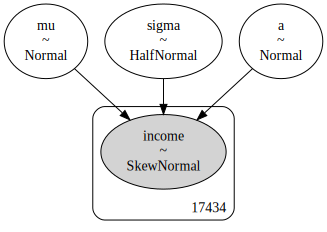

In [96]:
pm.model_to_graphviz(skew_normal_model)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a      3.65  0.11    3.44     3.85       0.01      0.0    425.77    693.28   
mu     1.80  0.02    1.77     1.83       0.00      0.0    434.27    808.07   
sigma  2.29  0.02    2.25     2.32       0.00      0.0    427.32    637.98   

       r_hat  
a       1.00  
mu      1.00  
sigma   1.01

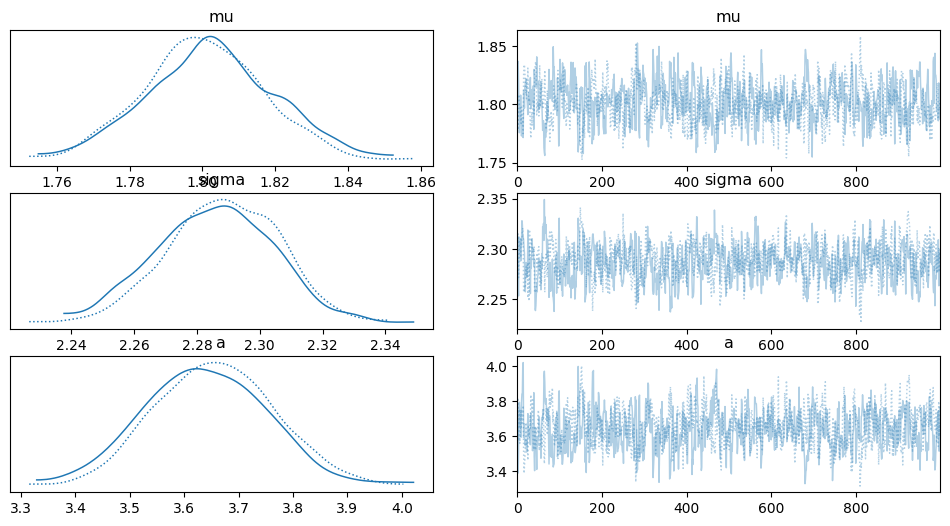

In [97]:
az.plot_trace(trace_skew_normal, var_names=["mu", "sigma", "a"])
az.summary(trace_skew_normal, round_to=2)

Les statistiques de convergence R̂ (R-hat) pour les trois paramètres sont égales à ~1, ce qui indique une excellente convergence des chaînes MCMC. Les différentes chaînes sont parvenues à une stationnarité.

In [98]:
with skew_normal_model:
    ppc = pm.sample_posterior_predictive(trace_skew_normal, var_names=["income"])

Output()

In [99]:
pd.Series(Income).describe()

count    17434.000000
mean         3.575593
std          1.443540
min          0.499900
25%          2.490150
50%          3.390600
75%          4.487950
max          8.011300
dtype: float64

In [100]:
predicted = ppc.posterior_predictive["income"]

# Calcul de statistiques descriptives sur les prédictions
predicted_mean = np.mean(predicted)
predicted_std = np.std(predicted)
hdi = az.hdi(predicted.values.flatten(), hdi_prob=0.94).round(2)



print(f"Moyenne prédictive : {predicted_mean:.2f}")
print(f"Écart-type prédictif : {predicted_std:.2f}")
print(f"Intervalle de crédibilité à 94 % : {hdi}")

Moyenne prédictive : 3.56
Écart-type prédictif : 1.46
Intervalle de crédibilité à 94 % : [1.13 6.37]


la moyenne des données observées (3,57) est très proche de la moyenne prédictive du modèle (3,56).

De même l'écart-type des données  (1,44) est également très similaire à l'écart-type prédictif (1,46).  

L'intervalle de crédibilité à 94% indique que la majorité des valeurs de la variable d'intérêt se trouvent dans la plage de 1.13 à 6.38. Or, les valeurs observées en dehors de cet intervalle suggèrent que des observations extrêmes peuvent être présentes dans vos données. Ce qui n'est pas idéal.

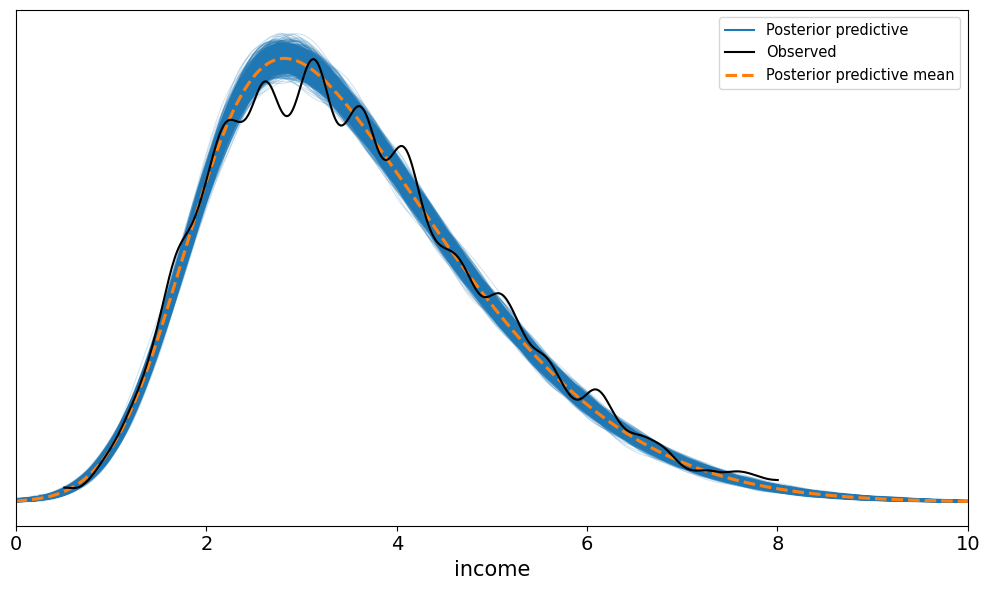

In [101]:
fig, ax = plt.subplots(figsize=(10, 6))
az.plot_ppc(ppc, ax=ax, kind='kde')
ax.set_xlim(0, 10)
plt.tight_layout()
plt.show()


Visuellement, la distribution prédictive a posteriori  semble globalement bien capturer la forme générale et la dispersion de la distribution observée.

Ainsi la vérification suggère que le modele est bien capable de générer des données qui ressemblent qualitativement aux données income observées.

## C- Households

Il s'agit d'une variable continue avec une distribution unimodale (avec un pic principal) centrée autour de 350, avec une asymétrie positive. Il y a une concentration importante des données autour de cette valeur, mais aussi une certaine dispersion vers des valeurs plus élevées.

Nous allons donc tester plusieurs variation d'un modele skew-normal

<Axes: >

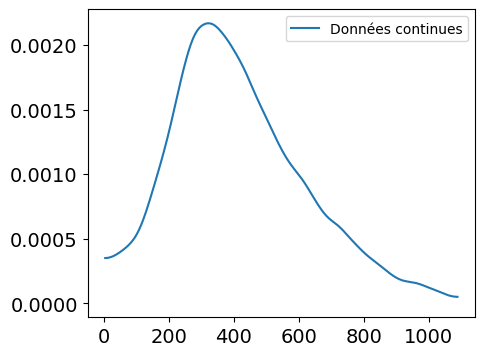

In [102]:
Households=Og_Housing['households'].values
plt.figure(figsize=(5, 4))
az.plot_dist(Households, label="Données continues")

### Création des modèles

In [103]:
with pm.Model() as skew_normal1:
  mu = pm.Normal("mu", mu=0, sigma=5)
  sigma = pm.HalfNormal("sigma", sigma=5)
  a = pm.Normal("a", mu=0, sigma=2)
  households_dist = pm.SkewNormal("households", mu=mu, sigma=sigma, alpha=a, observed=Households)
  trace_skew_normal1 = pm.sample(1000, tune=500, target_accept=0.95, idata_kwargs= {'log_likelihood': True})

Output()

In [104]:
with pm.Model() as skew_normal2:
  mu = pm.Normal("mu", mu=0, sigma=1)
  sigma = pm.HalfNormal("sigma", sigma=1)
  a = pm.Normal("a", mu=0, sigma=2)
  households_dist = pm.SkewNormal("households", mu=mu, sigma=sigma, alpha=a, observed=Households)
  trace_skew_normal2 = pm.sample(1000, tune=500, target_accept=0.95, idata_kwargs= {'log_likelihood': True})


Output()

In [105]:
with pm.Model() as skew_normal3:
  mu = pm.Normal("mu", mu=300, sigma=50)
  sigma = pm.HalfNormal("sigma", sigma=100)
  a = pm.Normal("a", mu=0, sigma=5)
  households_dist = pm.SkewNormal("households", mu=mu, sigma=sigma, alpha=a, observed=Households)
  trace_skew_normal3 = pm.sample  (1000, tune=500, target_accept=0.95, idata_kwargs= {'log_likelihood': True})


Output()

### Comparaison

In [106]:
comp1=pm.compare({
    "model_skew_normal1":trace_skew_normal1,
    "model_skew_normal2":trace_skew_normal2,
    "model_skew_normal3":trace_skew_normal3
})
comp1

rank       elpd_loo     p_loo     elpd_diff  weight  \
model_skew_normal3     0 -116922.109986  2.637494      0.000000     1.0   
model_skew_normal1     1 -117057.390102  2.421144    135.280116     1.0   
model_skew_normal2     2 -127459.998203  2.769071  10537.888217     0.0   

                            se         dse  warning scale  
model_skew_normal3   92.180367    0.000000    False   log  
model_skew_normal1  105.920502   16.881623    False   log  
model_skew_normal2  253.607982  186.774690    False   log

On remarque que dans ce cas, plus les priors sont informatifs, mieux se comporte le modèle.

### Résultat du meilleur modele - skew_normal3



mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a        2.89  0.08    2.76     3.04       0.00     0.00    543.83    720.54   
mu     181.01  2.50  176.10   185.57       0.11     0.08    519.95    574.13   
sigma  312.65  2.50  308.17   317.37       0.11     0.08    492.72    670.83   

       r_hat  
a        1.0  
mu       1.0  
sigma    1.0

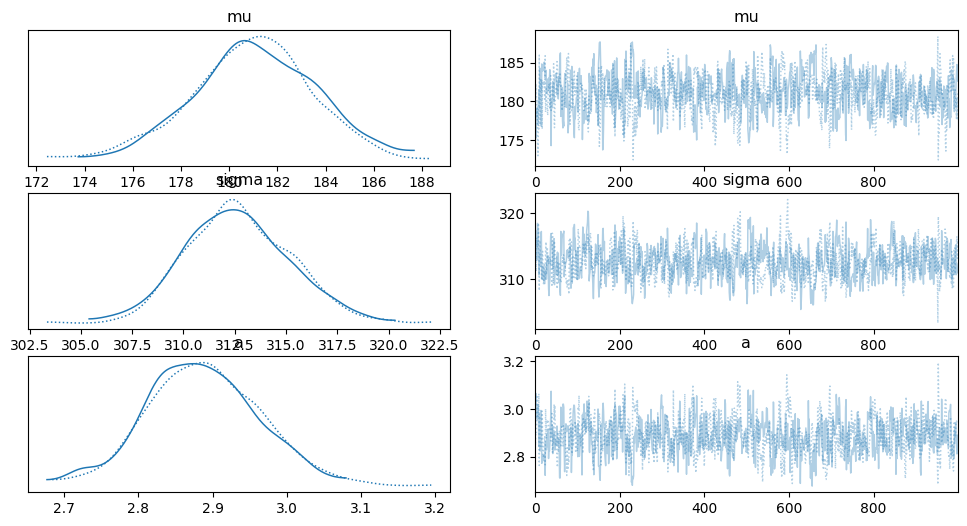

In [107]:
az.plot_trace(trace_skew_normal3, var_names=["mu", "sigma", "a"])
az.summary(trace_skew_normal3, round_to=2)

 Les chaînes semblent s'approcher de la stationnarité : les fluctuations autour de leurs moyennes respectives sont plus ou moins aléatoires et bornées, sans tendance claire à la hausse ou à la baisse sur le long terme.

 Les r_hat sont à 1

In [108]:
with skew_normal3:
    ppc = pm.sample_posterior_predictive(trace_skew_normal3, var_names=["households"])

Output()

In [109]:
pd.Series(Households).describe()

count    17434.000000
mean       416.806126
std        205.412687
min          2.000000
25%        271.000000
50%        387.000000
75%        540.000000
max       1090.000000
dtype: float64

In [110]:
pp= ppc.posterior_predictive["households"]

predicted_mean = np.mean(pp)
predicted_std = np.std(pp)
hdi = az.hdi(pp.values.flatten(), hdi_prob=0.94).round(2)

print(f"Moyenne prédictive : {predicted_mean:.2f}")
print(f"Écart-type prédictif : {predicted_std:.2f}")
print(f"Intervalle de crédibilité à 94 % : {hdi}")

Moyenne prédictive : 416.72
Écart-type prédictif : 205.44
Intervalle de crédibilité à 94 % : [ 63.98 814.04]


Les résultats statistiques sont plutôt satisfaisants, notamment les moyennes et les écarts-types prédictifs qui sont proches des valeurs observées.

En ce qui concerne l'intervalle de crédibilité, on remarque qu'un grand nombre des observations sont bien prises en compte par le modèle. Cependant, comme on peut s'y attendre d'un modèle normal, ce dernier sous-estime les valeurs extrêmes n'incluant donc pas le min et le max observé dans notre jeux de donnée.

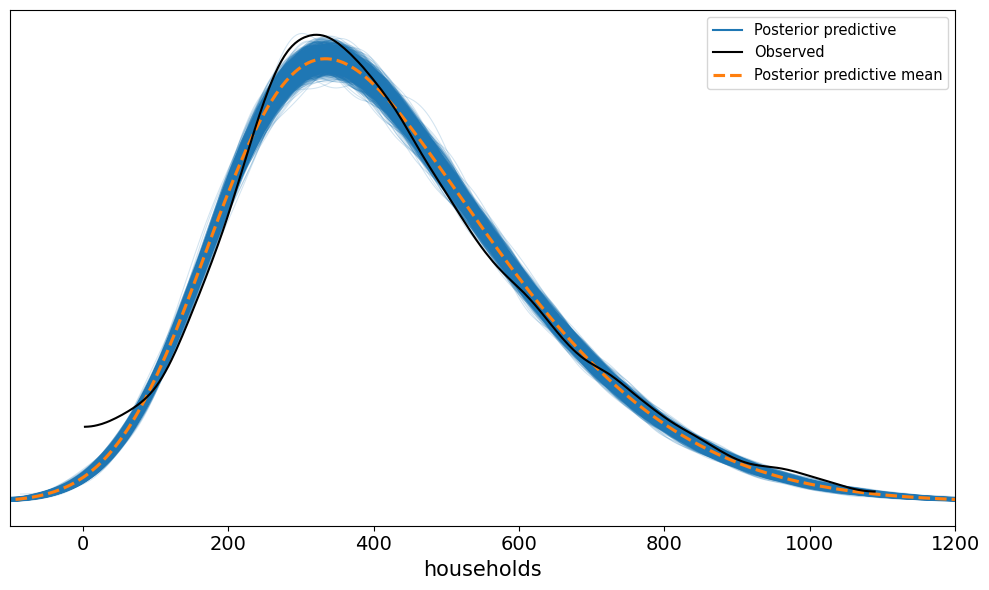

In [111]:
fig, ax = plt.subplots(figsize=(10, 6))
az.plot_ppc(ppc, ax=ax, kind='kde')
ax.set_xlim(-100, 1200)
plt.tight_layout()
plt.show()

Nous remarquons également une bonne adhérence visuelle entre les distributions prédites et les observations réelles, ce qui suggère que le modèle capture correctement la tendance générale des données, bien que certaines valeurs extrêmes ne soient pas aussi bien ajustées.

La moyenne prédictive suit de maniere satisfaisante la tendance générale de la distribution.

## D- Median Age

<Axes: >

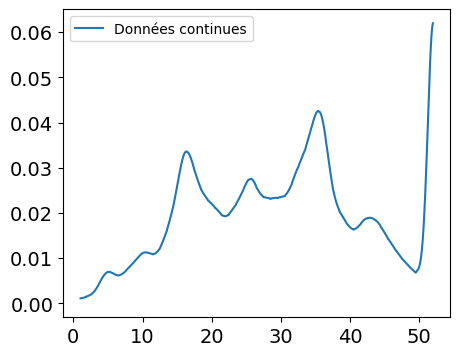

In [112]:
Age= Og_Housing['housing_median_age'].values
plt.figure(figsize=(5, 4))
az.plot_dist(Age, label="Données continues")

Pour modéliser la distribution de l'âge médian des maisons avec PyMC, en se basant sur la forme de la distribution, un modele multimodale pourrait être efficace.

Comme nous allons travailler sur des modèles complexes, j'ai opté pour un sous-échantillonnage de la variable Age afin de faciliter l'entraînement du modèle tout en conservant une représentation adéquate de la distribution des âges.

<Axes: >

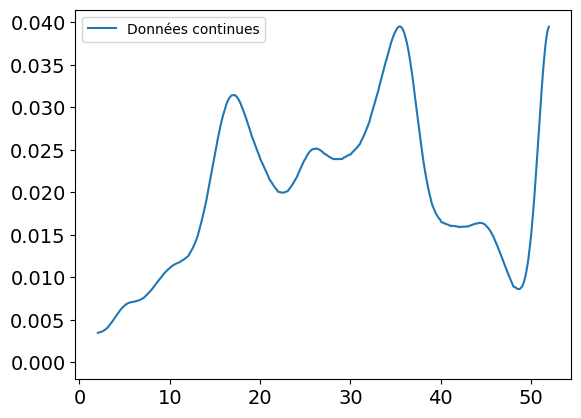

In [113]:
from sklearn.model_selection import train_test_split
Age,_ = train_test_split(Age, test_size=0.90, random_state=42)
az.plot_dist(Age, label="Données continues")

### Création des modèles

J'opte pour différente forme de mixture

In [114]:
#Trimodal

with pm.Model() as Trimodal:
    weights = pm.Dirichlet("weights", a=np.ones(3))
    mu = pm.Normal("mu", mu=np.linspace(Age.min(), Age.max(),3), sigma=10, shape=3)
    sd = pm.HalfNormal("sd", sigma=5, shape=3)

    category = pm.Categorical("category", p=weights, observed=np.zeros_like(Age, dtype=int))

    likelihood = pm.Normal("age", mu=mu[category], sigma=sd[category], observed=Age)

    trace1 = pm.sample(1000, tune=500, target_accept=0.9, idata_kwargs= {'log_likelihood': True})



Output()

In [115]:
#Quadrimodal

with pm.Model() as Quadrimodal:
    weights = pm.Dirichlet("weights", a=np.ones(4))
    mu = pm.Normal("mu", mu=np.linspace(Age.min(), Age.max(),4), sigma=10, shape=4)
    sd = pm.HalfNormal("sd", sigma=5, shape=4)

    category = pm.Categorical("category", p=weights, observed=np.zeros_like(Age, dtype=int))

    likelihood = pm.Normal("age", mu=mu[category], sigma=sd[category], observed=Age)

    trace2 = pm.sample(1000, tune=500, target_accept=0.9, idata_kwargs= {'log_likelihood': True})


Output()

In [116]:
with pm.Model() as mixture_skew_normal:
    weights = pm.Dirichlet("weights", a=np.ones(3))
    means = pm.Normal("means", mu=10, sigma=5, shape=3) # Priorité informative
    sd = pm.HalfNormal("sd", sigma=5, shape=3)
    a= pm.HalfNormal('a', sigma=5, shape=3) # Priorité faiblement informative

    components = pm.SkewNormal.dist(mu=means, sigma=sd, alpha=a)
    median_house_age_mixed = pm.Mixture("age", w=weights, comp_dists=components, observed=Age)

    trace3 = pm.sample(1000, tune=500, target_accept=0.9, idata_kwargs= {'log_likelihood': True})


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [117]:
with pm.Model() as mixture_skew_student:
    weights = pm.Dirichlet("weights", a=np.ones(3))
    means = pm.Normal("means", mu=10, sigma=5, shape=3) # Priorité informative
    sd = pm.HalfNormal("sd", sigma=5, shape=3)
    a= pm.HalfNormal('a', sigma=5, shape=3)
    b= pm.HalfNormal('b', sigma=5, shape=3)# Priorité faiblement informative

    components = pm.SkewStudentT.dist(mu=means, sigma=sd, a=a, b=b)
    median_house_age_mixed = pm.Mixture("age", w=weights, comp_dists=components, observed=Age)

    trace4 = pm.sample(1000, tune=500, target_accept=0.9, idata_kwargs= {'log_likelihood': True})


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


### Comparaison

In [118]:
com=az.compare({
    "Trimodal_normal":trace1,
    "Quadrimodal_normal":trace2,
    "Trimodal_skewnormal":trace3,
    "mixture_skew_student":trace4
},var_name="age")
com

rank     elpd_loo     p_loo  elpd_diff        weight  \
Trimodal_skewnormal      0 -6783.530951  8.874277   0.000000  1.000000e+00   
mixture_skew_student     1 -6792.239471  8.451655   8.708521  1.037748e-10   
Trimodal_normal          2 -6842.928323  1.554413  59.397372  8.045786e-13   
Quadrimodal_normal       3 -6843.113203  1.719132  59.582252  0.000000e+00   

                             se       dse  warning scale  
Trimodal_skewnormal   21.861715  0.000000    False   log  
mixture_skew_student  22.376115  1.249879    False   log  
Trimodal_normal       23.011100  9.551739    False   log  
Quadrimodal_normal    22.985332  9.557295    False   log

Le modèle Trimodal_skewnormal est celui qui a la meilleure performance parmi les trois, avec la valeur elpd_loo la plus élevée (la moins négative) et un poids de 1. Ce modèle a une meilleure capacité de prédiction par rapport aux autres.

### Résultat du meilleur modèle - Trimodal_skewnormal

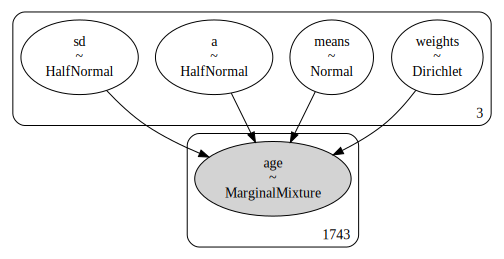

In [119]:
pm.model_to_graphviz(mixture_skew_normal)

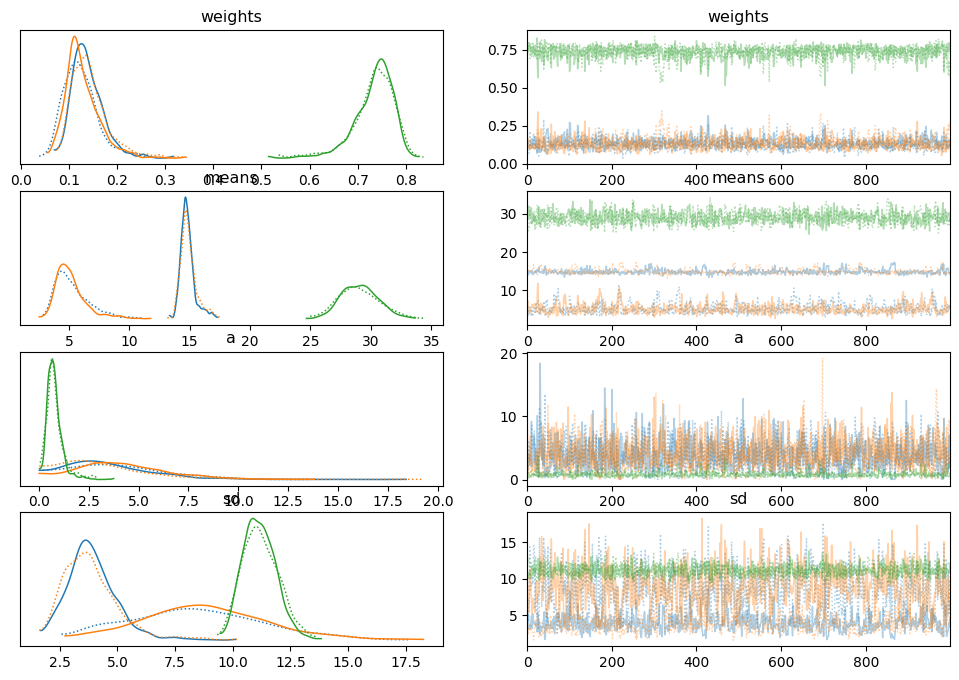

In [120]:
az.plot_trace(trace3, var_names=["weights", "means",'a', "sd"])
plt.show()

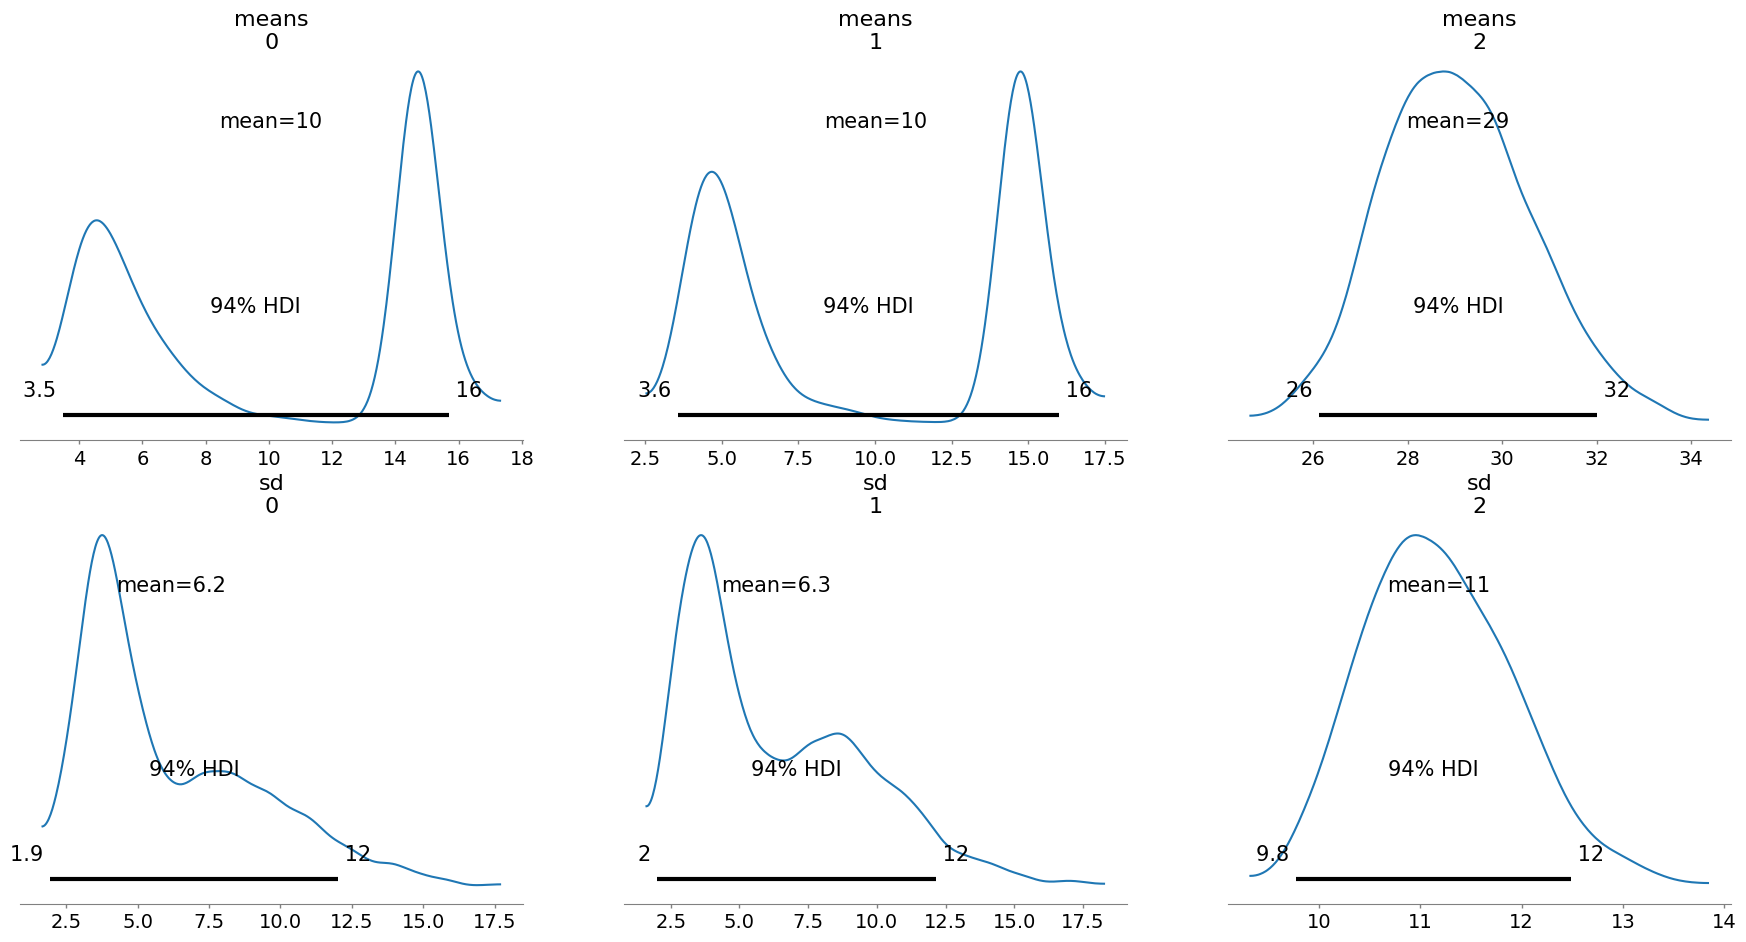

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
means[0]  10.07  4.89    3.49    15.68       3.37     0.04      2.94   
means[1]  10.03  4.99    3.56    16.00       3.46     0.04      2.95   
means[2]  29.06  1.58   26.12    32.02       0.05     0.04    976.33   
sd[0]      6.17  3.13    1.93    12.02       1.65     0.29      3.66   
sd[1]      6.35  3.27    2.01    12.14       1.84     0.14      3.30   
sd[2]     11.18  0.74    9.77    12.49       0.02     0.02   1028.30   

          ess_tail  r_hat  
means[0]     72.72   1.83  
means[1]     85.00   1.83  
means[2]    735.12   1.00  
sd[0]       109.74   1.54  
sd[1]       105.37   1.63  
sd[2]      1130.87   1.00

In [121]:
az.plot_posterior(trace3, var_names=["means", "sd"])
plt.show()
az.summary(trace3, var_names=["means", "sd"],round_to=2)

In [122]:
# Vérification prédictive a posteriori
with mixture_skew_normal:
    ppc = pm.sample_posterior_predictive(trace3)

Output()

In [123]:
pd.Series(Age).describe()

count    1743.000000
mean       29.209983
std        12.259375
min         2.000000
25%        19.000000
50%        30.000000
75%        37.000000
max        52.000000
dtype: float64

In [124]:
pp= ppc.posterior_predictive["age"]

predicted_mean = np.mean(pp)
predicted_std = np.std(pp)
hdi = az.hdi(pp.values.flatten(), hdi_prob=0.94).round(2)

print(f"Moyenne prédictive : {predicted_mean:.2f}")
print(f"Écart-type prédictif : {predicted_std:.2f}")
print(f"Intervalle de crédibilité à 94 % : {hdi}")

Moyenne prédictive : 29.15
Écart-type prédictif : 12.27
Intervalle de crédibilité à 94 % : [ 5.9  49.96]


Les moyennes prédictives similaires à celles observées (Moyenne : 29.15, Écart-type : 12.26)

<ipython-input-125-91acc42c7a70>:4: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



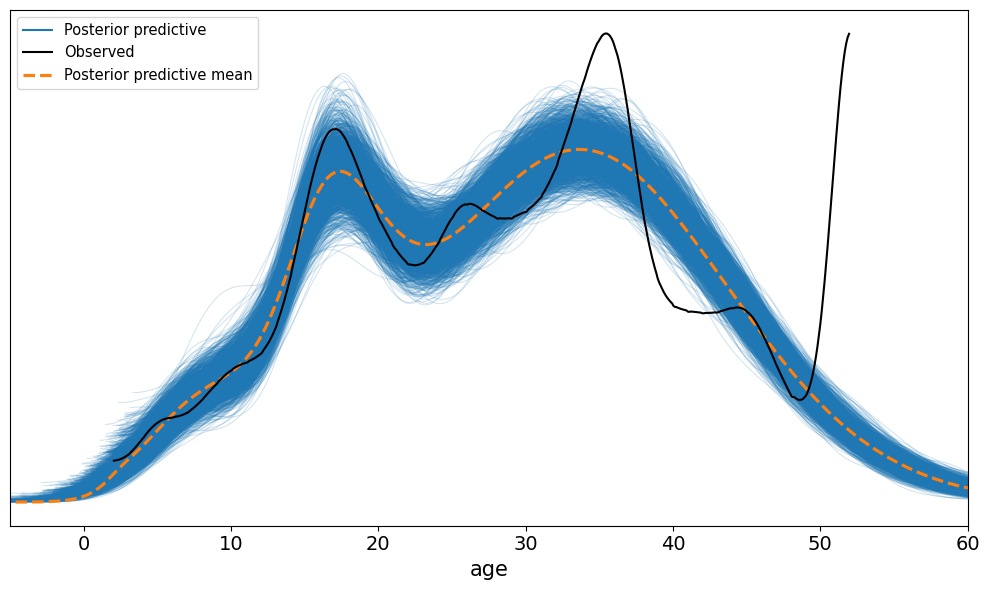

In [125]:
fig, ax = plt.subplots(figsize=(10, 6))
az.plot_ppc(ppc, ax=ax, kind='kde')
ax.set_xlim(-5, 60)
plt.tight_layout()
plt.show()

Visuellement, l’ajustement du modèle, bien que non parfait, demeure globalement très satisfaisant. On observe une bonne concordance entre les courbes de densité prédictives postérieures et la distribution empirique, notamment dans les zones centrales de la distribution.

La moyenne prédictive suit de manière la tendance générale de la distribution.

Certaines zones présentent des écarts notables, en particulier aux extrémités de la distribution (au-delà de 50 ans, par exemple), où le modèle tend à lisser davantage que la courbe observée. Cela peut s’expliquer par la nature de la distribution normale, qui représente mal des comportements extrêmes.

# Conclusion

Ce travail a permis d'explorer l'application de méthodes bayésiennes avancées à la modélisation de données complexes issues du jeu de données California Housing.

Dans un premier temps, la régression linéaire bayésienne sur median_house_value a mis en évidence l’effet significatif de plusieurs variables explicatives, tout en fournissant des intervalles de crédibilité permettant une interprétation plus nuancée que les simples intervalles de confiance fréquentistes. Les distributions postérieures des coefficients, ainsi que les prédictions issues du posterior predictive check, ont montré une bonne capacité du modèle à capturer la tendance centrale et la dispersion des données observées.

Après avoir identifié les variables les plus pertinentes, nous avons proposé une manière de les modéliser.

La modélisation des variables catégorielles, comme ocean_proximity, à l’aide de modèles multinouilliens et multinomiaux bayésiens, a révélé une forte concordance entre les proportions postérieures estimées et les proportions observées. Les diagnostics LOO et WAIC, bien que légèrement affectés par le caractère agrégé des données, ont confirmé la qualité des ajustements.

Pour les variables continues (income, age), l'ajustement de distributions asymétriques (Skew Normal, Student, Skew Student) et de mélanges de lois a permis de capturer plus fidèlement les formes complexes des distributions empiriques, notamment les queues épaisses et la multimodalité. Les comparaisons par critères d'information (elpd_loo, WAIC) ont systématiquement favorisé les modèles les plus flexibles.

En somme, ce travail illustre l'efficacité des méthodes bayésiennes pour modéliser, prédire et interpréter des données complexes. Il constitue une base solide pour des analyses futures incluant des structures plus riches, notamment spatio-temporelles ou multi-niveaux.